# Sentiment Analysis on

In [214]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import zscore
from statsmodels.tsa.stattools import grangercausalitytests
import jieba
from snownlp import SnowNLP
import tushare as ts
import akshare as ak
from statsmodels.tsa.stattools import adfuller, coint, kpss,grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare
from linearmodels.iv import IV2SLS
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [217]:
def SentimentIndex(df, stock):
    trade_date = stock['trade_date'].tolist()
    trade_date = sorted(trade_date)
    for i in range(len(trade_date)-1):
        start_time = pd.to_datetime(trade_date[i].strftime('%Y%m%d')+ ' ' + '15:00')
        end_time = pd.to_datetime((trade_date[i+1].strftime('%Y%m%d') + ' ' + '15:00'))
        df_sentiment = df[(df['post_datetime']>start_time) & (df['post_datetime']<=end_time)]
        if df_sentiment.empty:
            continue
        else:
            sentiment_index = (sum(df_sentiment['pos_num']) - sum(df_sentiment['neg_num']))/sum(df_sentiment['word_num'])
            stock.loc[stock['trade_date'] == pd.to_datetime(trade_date[i+1]).strftime('%Y%m%d'), 'sentiment_index'] = sentiment_index
            #snownlp_index = (sum(df_sentiment['snownlp'])/len(df_sentiment['snownlp']))
            #stock.loc[stock['trade_date'] == pd.to_datetime(trade_date[i+1]).strftime('%Y%m%d'), 'snownlp_index'] = snownlp_index
    return stock


In [218]:
def get_stock_data(stock_id, start_time, end_time):
    ## 个股数据

    pro = ts.pro_api('2876ea85cb005fb5fa17c809a98174f2d5aae8b1f830110a5ead6211')
# 拉取数据

# 拉取数据
    stock_daily_basic = pro.daily_basic(**{
        "ts_code": stock_id,
        "trade_date": "",
        "start_date": start_time,
        "end_date": end_time,
        "limit": "",
        "offset": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "turnover_rate",
        "pe",
        "pb"
    ])



# 拉取数据
    stock_daily = pro.daily(**{
        "ts_code": stock_id,
        "trade_date": "",
        "start_date": start_time,
        "end_date": end_time,
        "offset": "",
        "limit": ""
    }, fields=[
        "ts_code",
        "trade_date",
        "open",
        "high",
        "low",
        "close",
        "vol",
        "amount"
    ])


    if stock_daily.empty:
        print(f'{stock_id} stock 行情数据 is empty')
    if stock_daily_basic.empty:
        print(f'{stock_id} stock 每日指标 is empty')
    stock  = stock_daily.merge(stock_daily_basic, how='left', on=['ts_code', 'trade_date'])
    return stock

In [219]:
def winsorize_series(series, lower=0.01, upper=0.99):
    """
    对收益率序列进行缩尾处理
    :param series: pandas Series, 收益率序列
    :param lower: 下缩尾分位数（默认1%）
    :param upper: 上缩尾分位数（默认99%）
    :return: 缩尾后的Series
    """
    # 计算分位数边界
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)

    # 执行缩尾（极端值替换为边界值）
    return series.clip(lower=lower_bound, upper=upper_bound)


In [220]:
def stock_processed(result):
    result['agreement_index'] = result['sentiment_index'].apply(lambda x : 1-np.sqrt(1-x**2))
    result['return'] = np.log(result['close']/result['close'].shift(1))*100
    result['return'] = result['return'].fillna(0)
    result['volatility'] = (result['high'] - result['low'])/((result['high']+result['low'])/2)*100
    result = result[~result['sentiment_index'].isna()].reset_index(drop=True)
    result = result.rename(columns={'return': 'returns'}).copy()

    result['returns_new'] = winsorize_series(result['returns'])
    result['log_volatility'] = np.log(result['volatility']/100 + 1e-5).pipe(lambda x: (x - x.mean())/x.std())*100

    result['sentiment_index_lag_1'] = result['sentiment_index'].shift(1).fillna(0)

    result['turnover_rate_new'] = result['turnover_rate'].apply(lambda x: np.log(1+x))
    result['pe_new'] = winsorize_series(result['pe'], lower=0.01, upper=0.99)
    result['pb_new'] = winsorize_series(result['pb'], lower=0.01, upper=0.99)

    return result

### Data Cleaning and Pre-processing

### 工具变量数据

In [463]:
baidu_index = pd.read_csv('沪深300指数百度指数.csv', encoding='gbk')

In [464]:
baidu_index['日期'] = pd.to_datetime(baidu_index['日期'])

### 数据预处理与平稳性检验

In [202]:
result = result.rename(columns={'return': 'returns'}).copy()

In [ ]:
result = result[~result['sentiment_index'].isna()].reset_index(drop=True)

In [244]:
result.columns

Index(['ts_code', 'trade_date', 'close', 'open', 'high', 'low', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount', 'total_mv', 'float_mv',
       'turnover_rate', 'pe', 'pb', 'total_share', 'm2_yoy', 'sentiment_index',
       'agreement_index', 'returns', 'volatility', 'volume_million',
       'returns_new', 'log_volatility', 'sentiment_index_lag_1',
       'sentiment_index_lag_2', 'sentiment_index_square', 'turnover_rate_new',
       'pe_new', 'pb_new'],
      dtype='object')

In [293]:
data = result[['trade_date', 'sentiment_index', 'sentiment_index_lag_1', 'sentiment_index_square', 'agreement_index', 'returns_new', 'volatility', 'log_volatility', 'pe_new', 'pe','pb','pb_new', 'm2_yoy', 'turnover_rate_new']].copy()

In [294]:
# 初步数据处理，标注化
# 1.1 Z-Score标准化（适用于收益率、波动率）
cols_to_standardize = ['returns_new', 'log_volatility','sentiment_index', 'sentiment_index_lag_1']
data_std = data[cols_to_standardize].apply(lambda x: (x - x.mean())/x.std())


In [295]:
# 1.2 Min-Max标准化（适用于交易量）
cols_to_minmax = []
# data_minmax = data[cols_to_minmax].apply(lambda x: (x - x.min())/(x.max() - x.min()))

In [296]:
# 合并标准化后数据（保留原始数据）
data_processed = pd.concat([data.drop(columns=cols_to_standardize+cols_to_minmax),
                           data_std], axis=1)

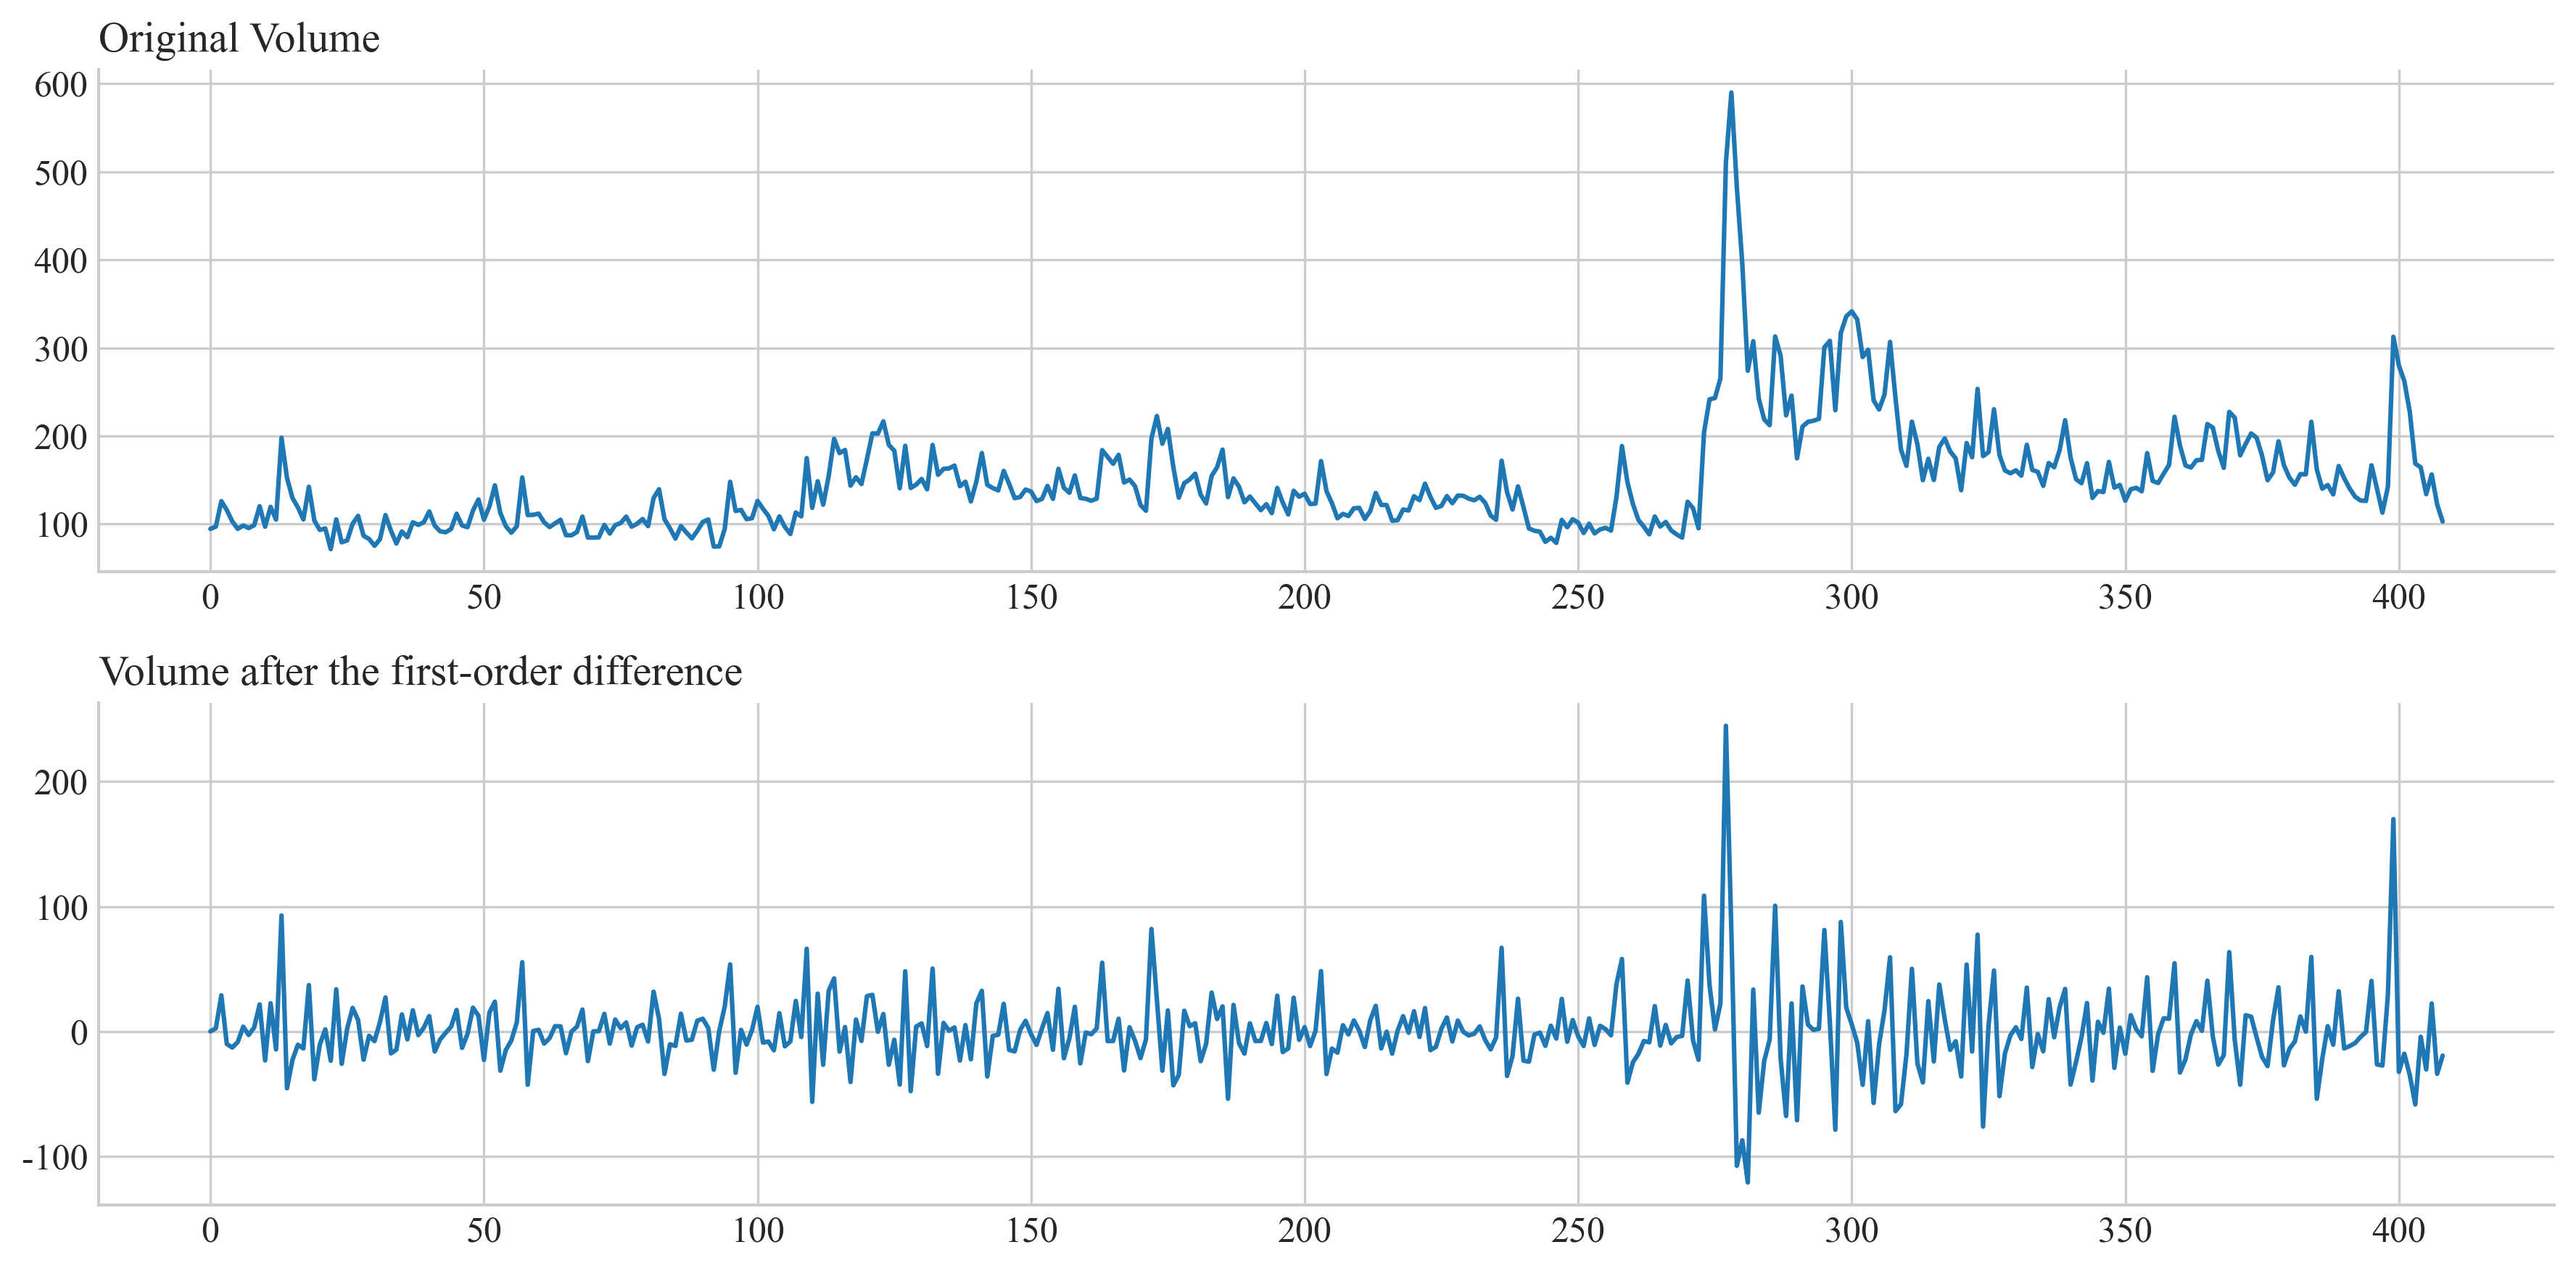

In [84]:
data['volume_diff1'] = data['volume_million'].diff(1)
data['volume_diff1'] = data['volume_diff1'].fillna(0)
# 一阶差分后可视化对比
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
data['volume_million'].plot(ax=ax[0], title='Original Volume')
data['volume_diff1'].plot(ax=ax[1], title='Volume after the first-order difference')
plt.tight_layout()
plt.show()

In [85]:
data.head(3)

,trade_date,sentiment_index,agreement_index,volume_million,returns,volatility,volume_diff1
0,2023-08-09,0.023569,0.000278,94.640269,0.000000,0.510217,0.000000
1,2023-08-10,0.010249,0.000053,97.176849,0.205240,0.784584,2.536580
2,2023-08-11,0.012405,0.000077,126.082931,-2.327412,2.384298,28.906082


In [83]:
len(data)

409

In [80]:
data = result[['trade_date', 'sentiment_index', 'agreement_index', 'volume_million', 'return', 'volatility']].copy()

#### volume 处理

In [239]:
print("原始【PE】描述统计：")
print(result['pe'].describe())

print("\n【缩尾后PE】描述统计：")
print(result['pe_new'].describe())

原始【PE】描述统计：
count    409.000000
mean      11.904694
std        0.801411
min       10.410000
25%       11.310000
50%       11.750000
75%       12.750000
max       13.830000
Name: pe, dtype: float64

【缩尾后PE】描述统计：
count    409.000000
mean      11.904367
std        0.797082
min       10.560800
25%       11.310000
50%       11.750000
75%       12.750000
max       13.418400
Name: pe_new, dtype: float64


In [241]:
print("【原始PB】描述统计：")
print(result['pb'].describe())

print("\n【缩尾后PB】描述统计：")
print(result['pb_new'].describe())

【原始PB】描述统计：
count    409.000000
mean       1.279756
std        0.065962
min        1.150000
25%        1.240000
50%        1.270000
75%        1.340000
max        1.480000
Name: pb, dtype: float64

【缩尾后PB】描述统计：
count    409.000000
mean       1.279487
std        0.065342
min        1.150000
25%        1.240000
50%        1.270000
75%        1.340000
max        1.400000
Name: pb_new, dtype: float64


In [238]:
#市盈率（PE）和市净率（PB）是常用的估值指标，但它们容易受到极端值的影响。为了减少极端值对回归模型的影响，可以对这些指标进行缩尾处理（Winsorization）。缩尾处理的基本思想是将数据的上下极端值替换为某个分位数的值，从而“压缩”数据的尾部。
def winsorize_series(series, lower=0.01, upper=0.99):
    """
    对单个序列进行缩尾处理
    :param series: pandas Series
    :param lower: 下分位数阈值（默认1%）
    :param upper: 上分位数阈值（默认99%）
    :return: 缩尾后的Series
    """
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower=lower_bound, upper=upper_bound)

# 对PE和PB列分别应用缩尾处理
result['pe_new'] = winsorize_series(result['pe'], lower=0.01, upper=0.99)
result['pb_new'] = winsorize_series(result['pb'], lower=0.01, upper=0.99)

# 可选：直接覆盖原始列（谨慎操作）
# df['PE'] = winsorize_series(df['PE'])
# df['PB'] = winsorize_series(df['PB'])


#### PE,PB

In [236]:
print(result['turnover_rate_new'].describe())

count    409.000000
mean       0.380812
std        0.116614
min        0.207014
25%        0.300105
50%        0.357674
75%        0.431782
max        1.054312
Name: turnover_rate_new, dtype: float64


In [235]:
print(result['turnover_rate'].describe())

count    409.000000
mean       0.474181
std        0.193379
min        0.230000
25%        0.350000
50%        0.430000
75%        0.540000
max        1.870000
Name: turnover_rate, dtype: float64


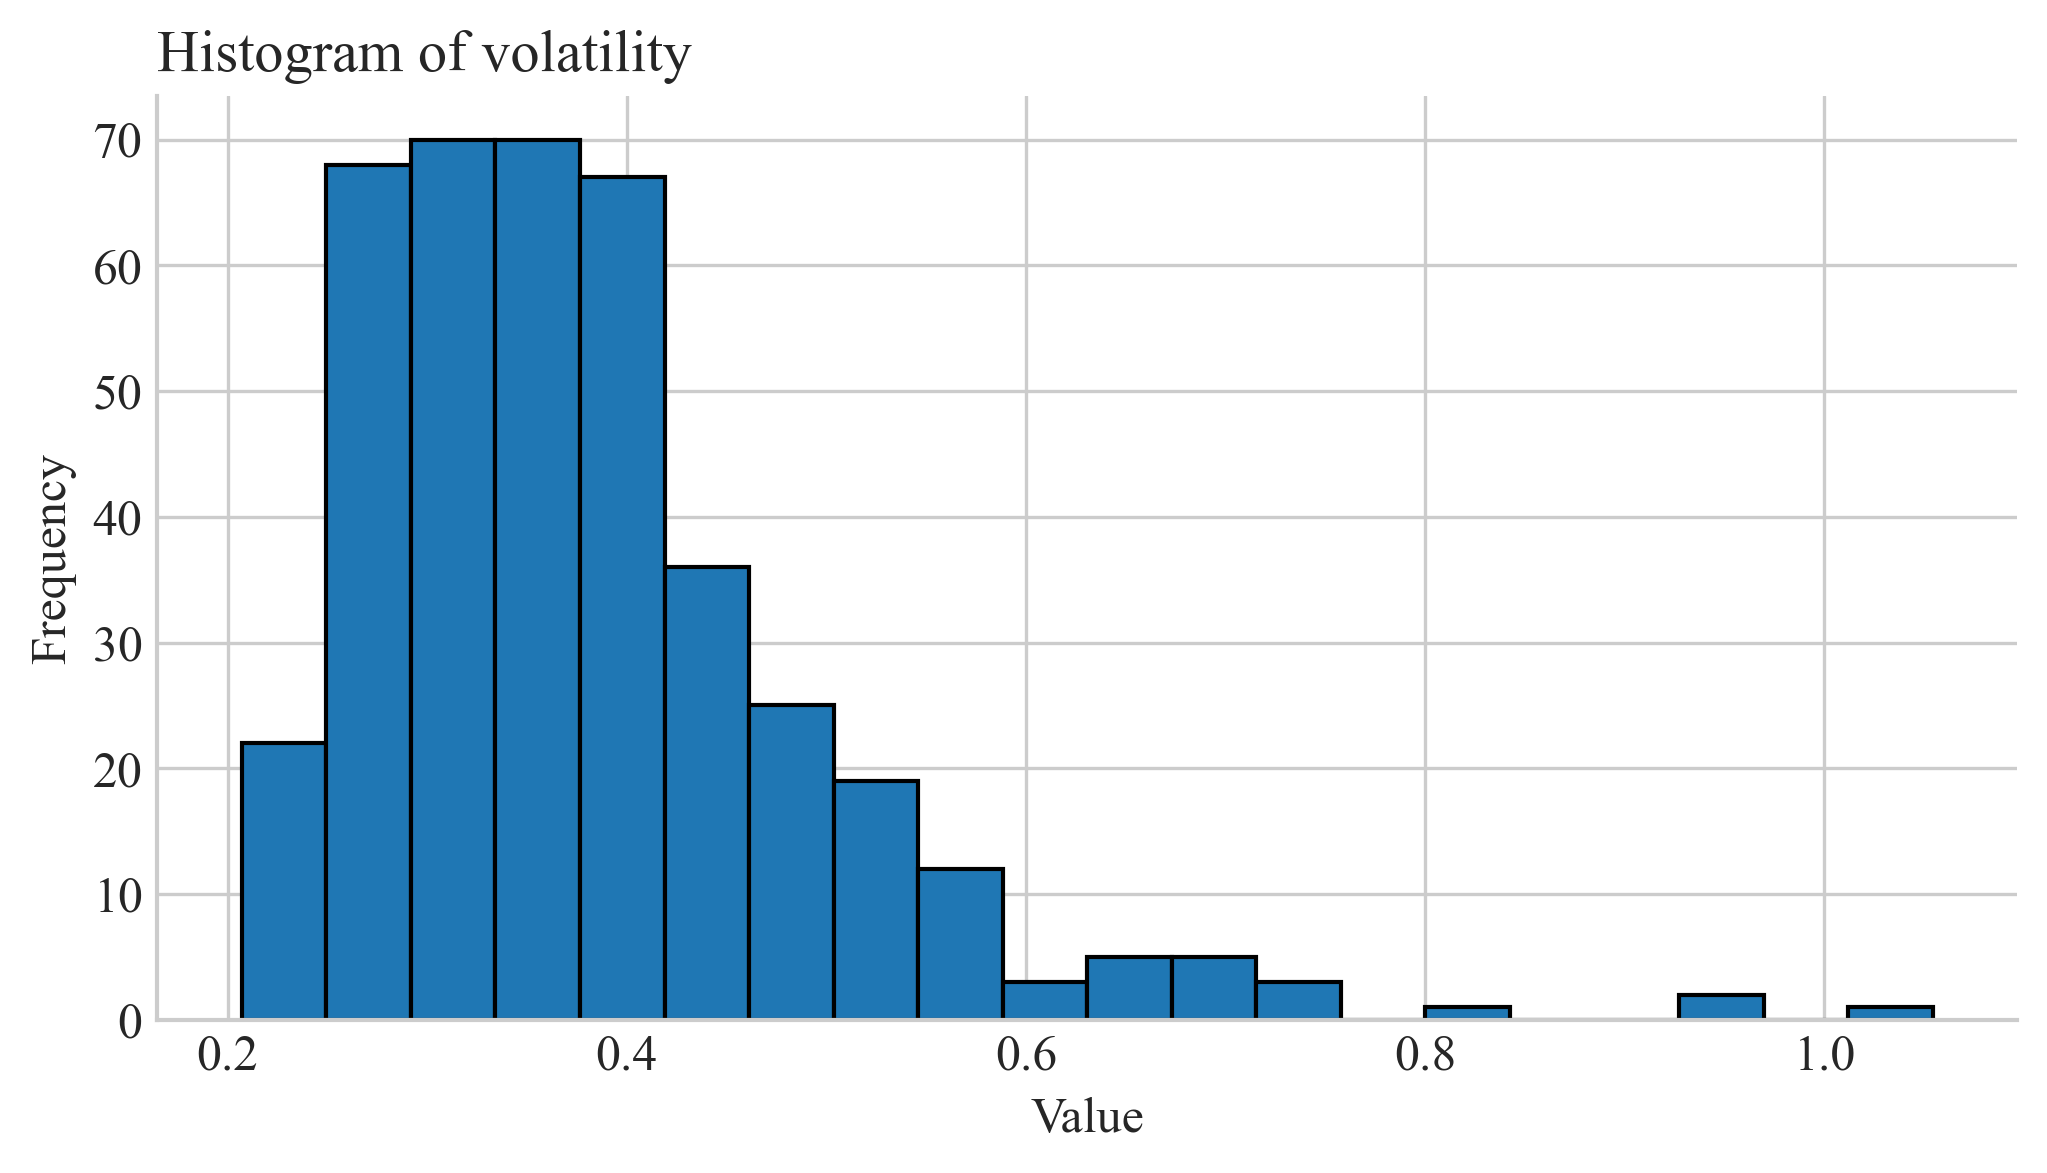

In [234]:
plt.hist(result['turnover_rate_new'], bins=20, edgecolor='k')
plt.title('Histogram of volatility')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [233]:
#换手率常呈右偏分布，取ln(1+x)改善对称性
result['turnover_rate_new'] = result['turnover_rate'].apply(lambda x: np.log(1+x))

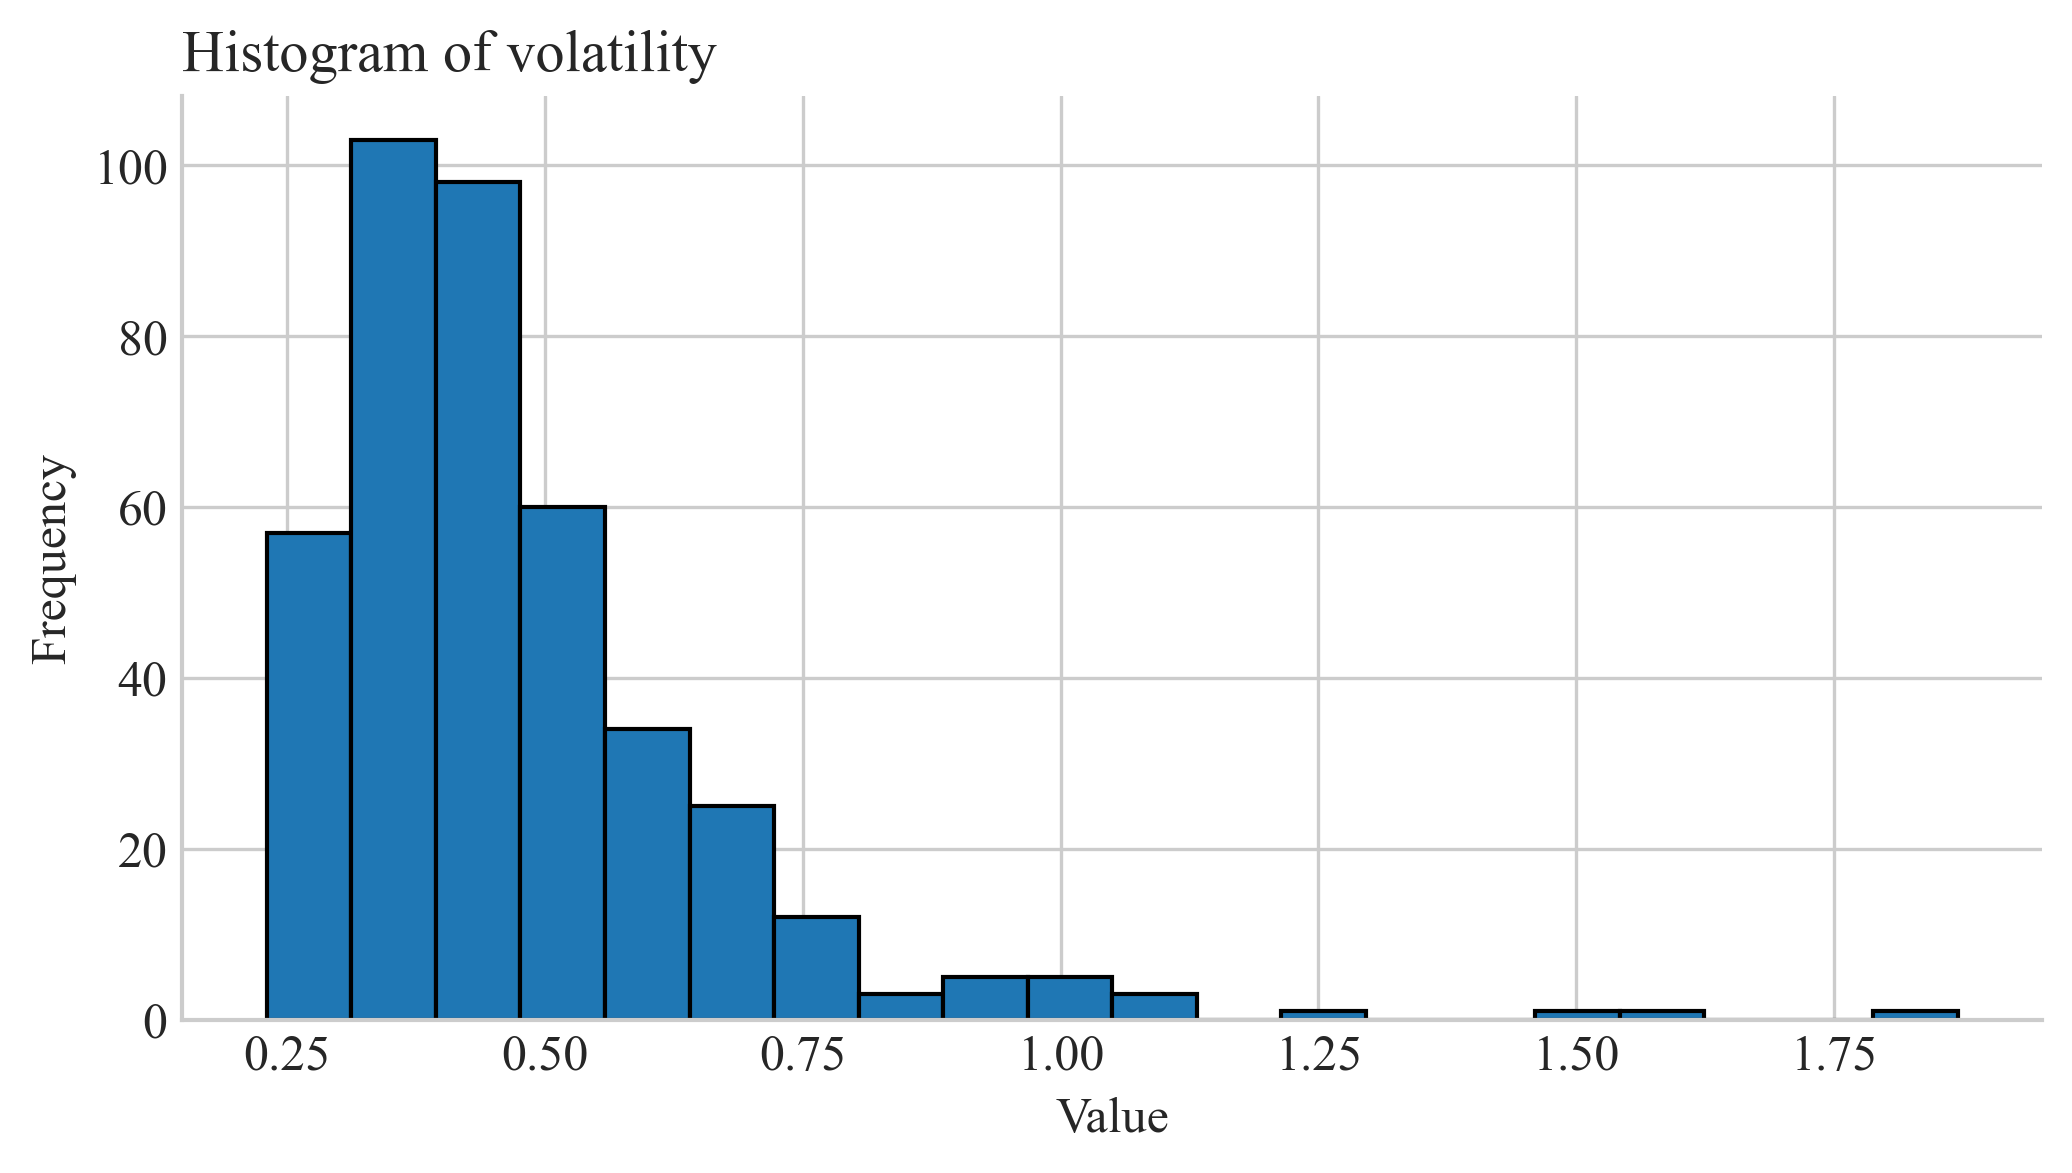

In [232]:
# 直方图
plt.hist(result['turnover_rate'], bins=20, edgecolor='k')
plt.title('Histogram of volatility')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#### turnover

#### agreement Logit变换

In [231]:
print(len(result[result['sentiment_index']==0]))

37


In [230]:
print(len(result[result['sentiment_index']<0]))

120


In [229]:
print(len(result[result['sentiment_index']>0]))

252


In [228]:
print(result['sentiment_index'].describe())

count    409.000000
mean       0.006535
std        0.017926
min       -0.046392
25%       -0.004535
50%        0.005758
75%        0.018809
max        0.059524
Name: sentiment_index, dtype: float64


In [227]:
result[['trade_date','sentiment_index', 'sentiment_index_lag_1']].head(3)

,trade_date,sentiment_index,sentiment_index_lag_1
0,2023-08-09,0.023569,0.000000
1,2023-08-10,0.010249,0.023569
2,2023-08-11,0.012405,0.010249


In [225]:
result['sentiment_index_square'] = result['sentiment_index']**2

In [224]:
result['sentiment_index_lag_2'] = result['sentiment_index'].shift(2).fillna(0)

In [223]:
result['sentiment_index_lag_1'] = result['sentiment_index'].shift(1).fillna(0)

#### sentiment_index_lag 加入

In [222]:
print(result['volatility'].describe())

count    409.000000
mean       1.355402
std        0.908618
min        0.360828
25%        0.846813
50%        1.097468
75%        1.499679
max        8.332997
Name: volatility, dtype: float64


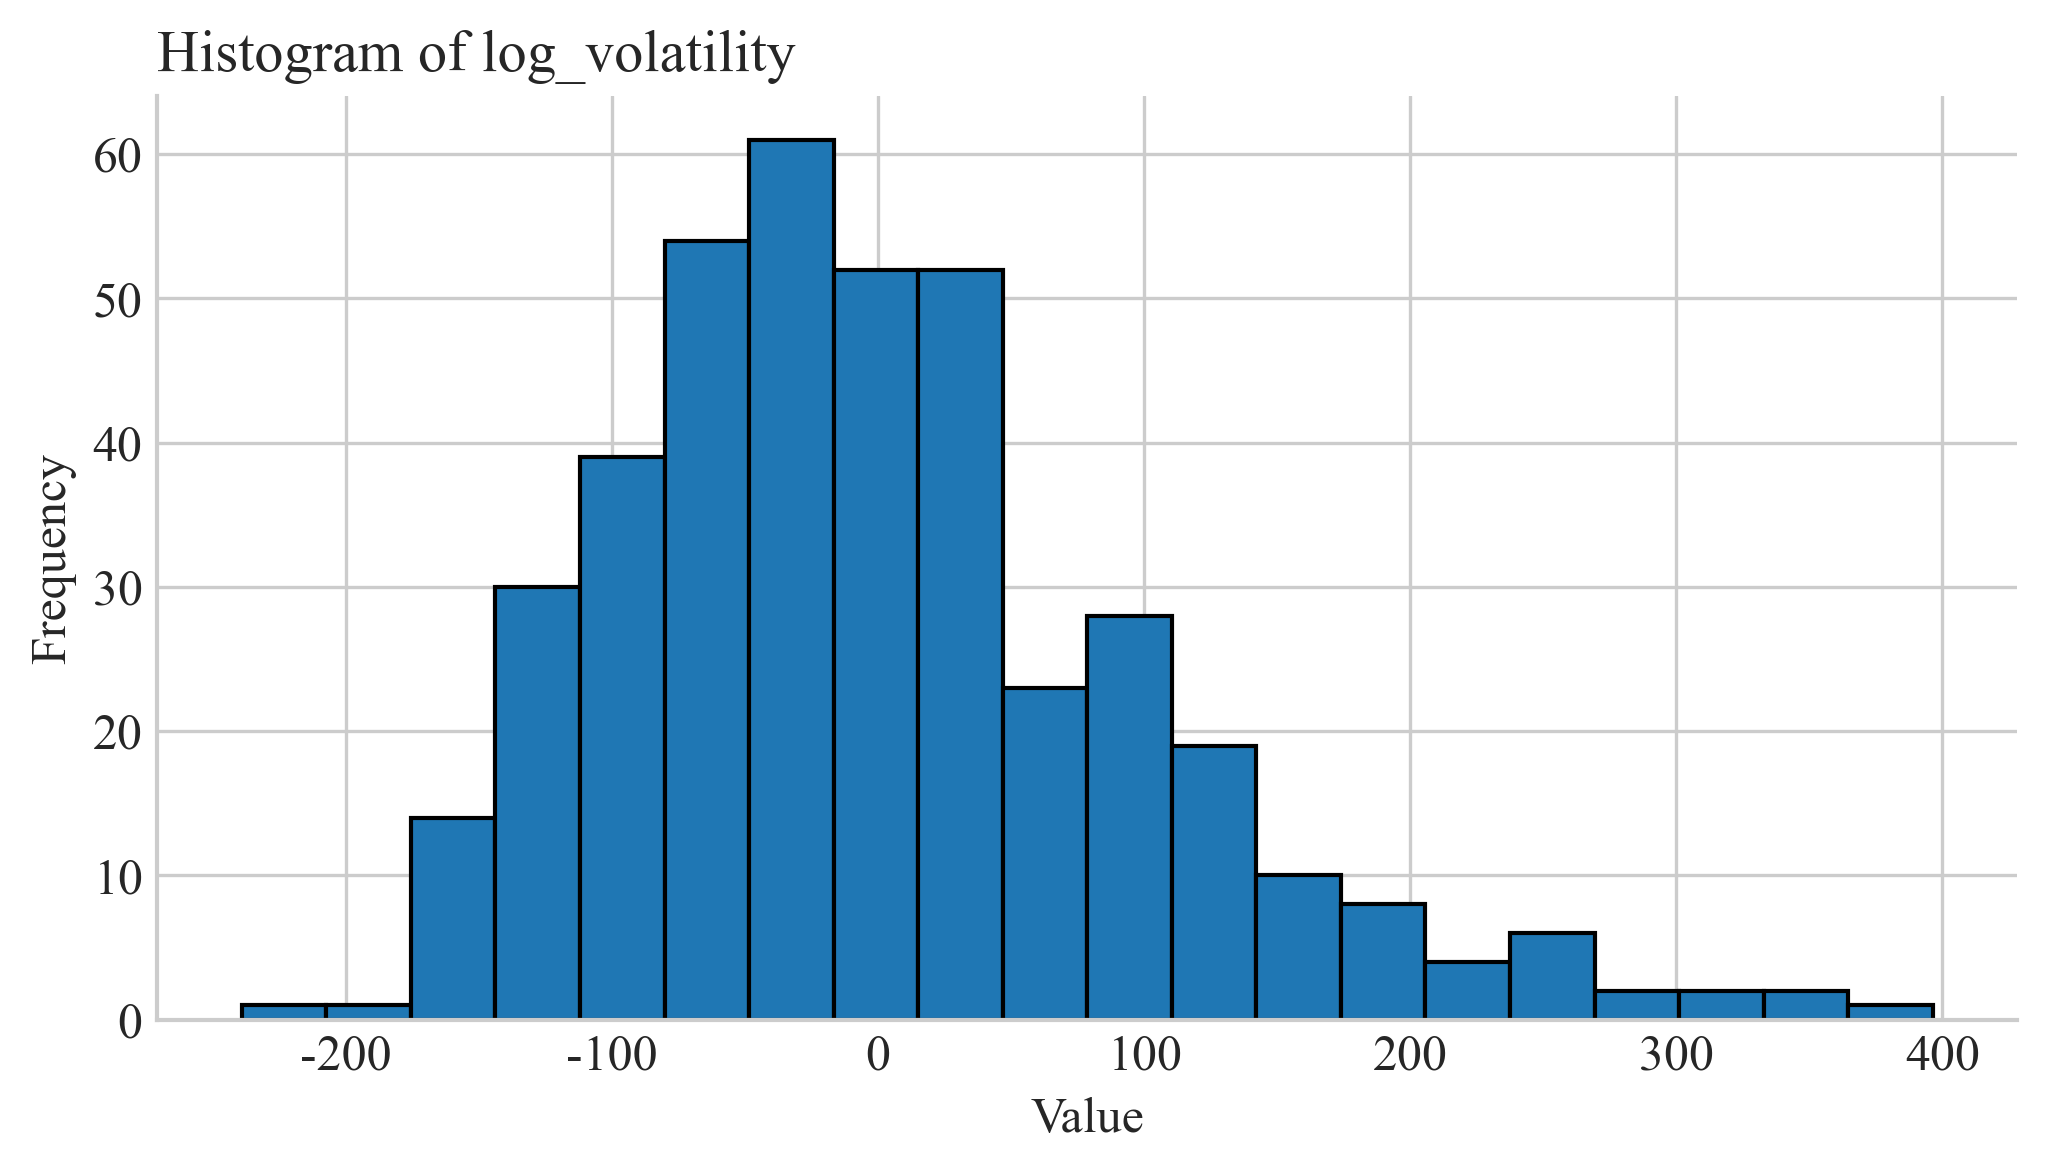

In [221]:
plt.hist(result['log_volatility'], bins=20, edgecolor='k')
plt.title('Histogram of log_volatility')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [219]:
result['log_volatility'] = np.log(result['volatility']/100 + 1e-5).pipe(lambda x: (x - x.mean())/x.std())*100

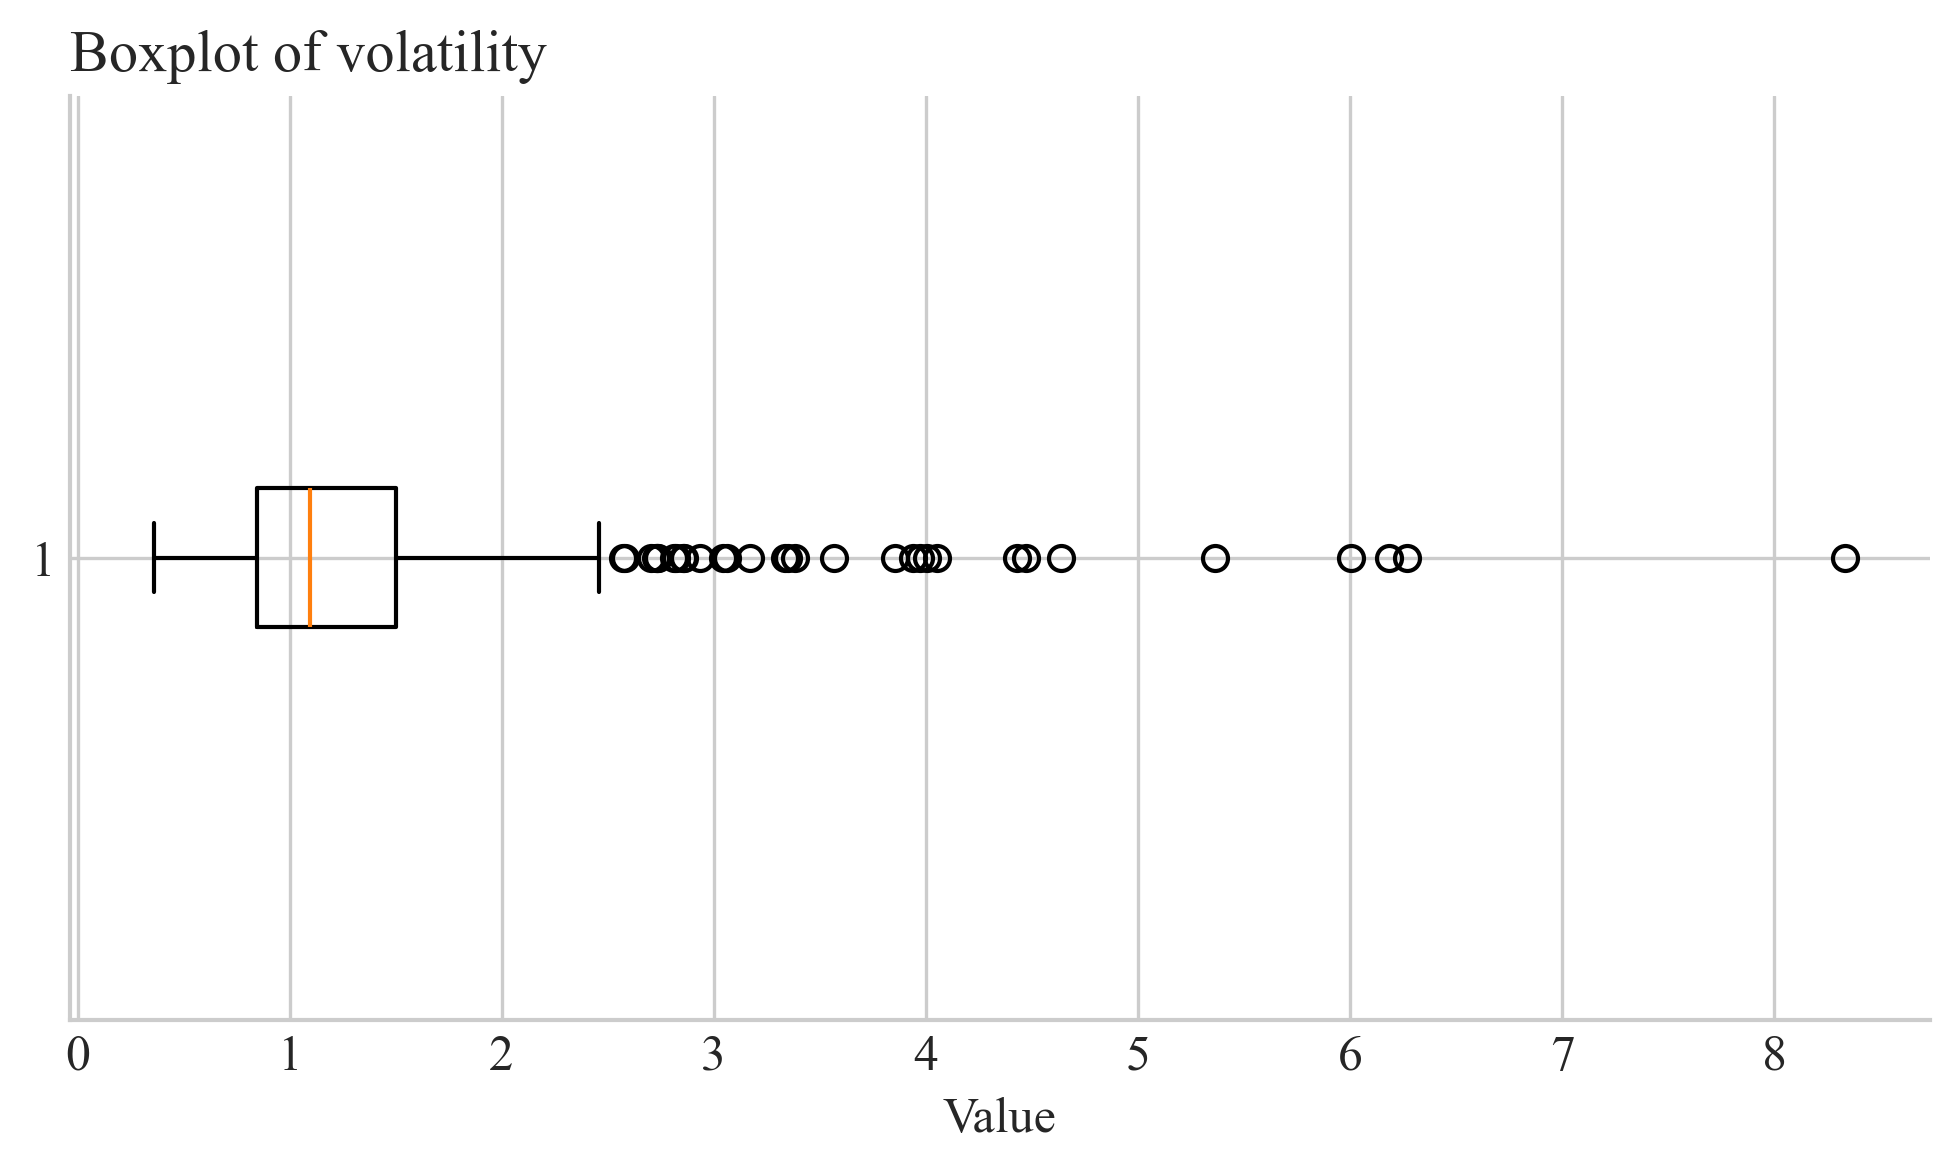

In [218]:
# 绘制箱线图
plt.boxplot(result['volatility'], vert=False)
plt.title('Boxplot of volatility')
plt.xlabel('Value')
plt.show()

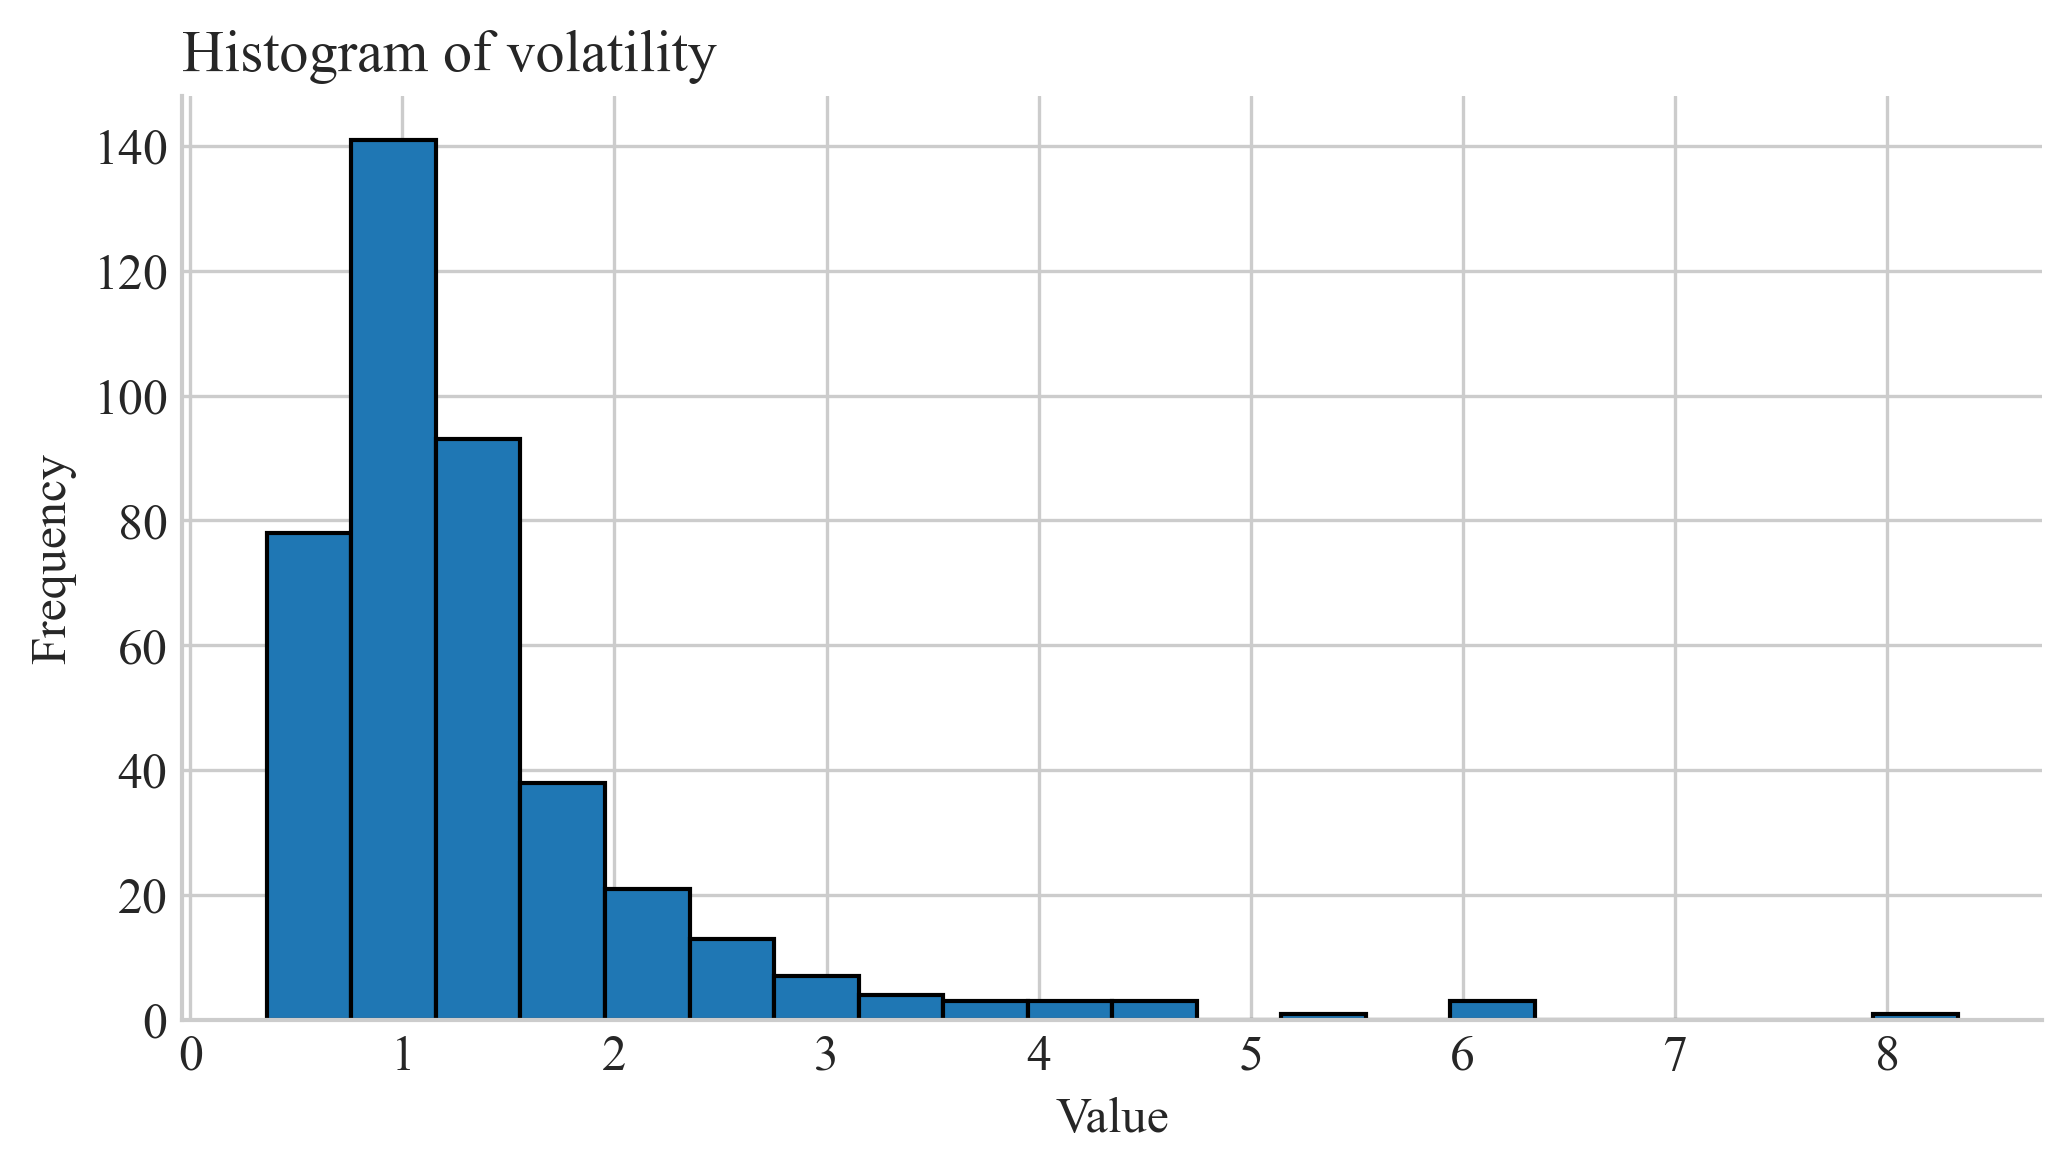

In [217]:
# 直方图
plt.hist(result['volatility'], bins=20, edgecolor='k')
plt.title('Histogram of volatility')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [216]:
result['volatility'].skew()

3.221541875862905

In [215]:
result['volatility'].kurt()

15.00511258328043

#### volatility 分布检验和绘图

In [214]:
print("【原始收益率】描述统计：")
print(result['returns'].describe())

print("\n【缩尾后收益率】描述统计：")
print(result['returns_new'].describe())

【原始收益率】描述统计：
count    409.000000
mean      -0.012325
std        1.220647
min       -7.312301
25%       -0.602439
50%       -0.044578
75%        0.476257
max        8.141981
Name: returns, dtype: float64

【缩尾后收益率】描述统计：
count    409.000000
mean      -0.004127
std        1.042977
min       -2.797204
25%       -0.602439
50%       -0.044578
75%        0.476257
max        4.093248
Name: returns_new, dtype: float64


In [213]:
# 缩尾处理
def winsorize_returns(series, lower=0.01, upper=0.99):
    """
    对收益率序列进行缩尾处理
    :param series: pandas Series, 收益率序列
    :param lower: 下缩尾分位数（默认1%）
    :param upper: 上缩尾分位数（默认99%）
    :return: 缩尾后的Series
    """
    # 计算分位数边界
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)

    # 执行缩尾（极端值替换为边界值）
    return series.clip(lower=lower_bound, upper=upper_bound)

# 示例应用
result['returns_new'] = winsorize_returns(result['returns'])

# 可选：非对称缩尾（仅处理单侧极端值）
# df['Returns_winsorized'] = winsorize_returns(df['Returns_t'], lower=0.01, upper=0.95)

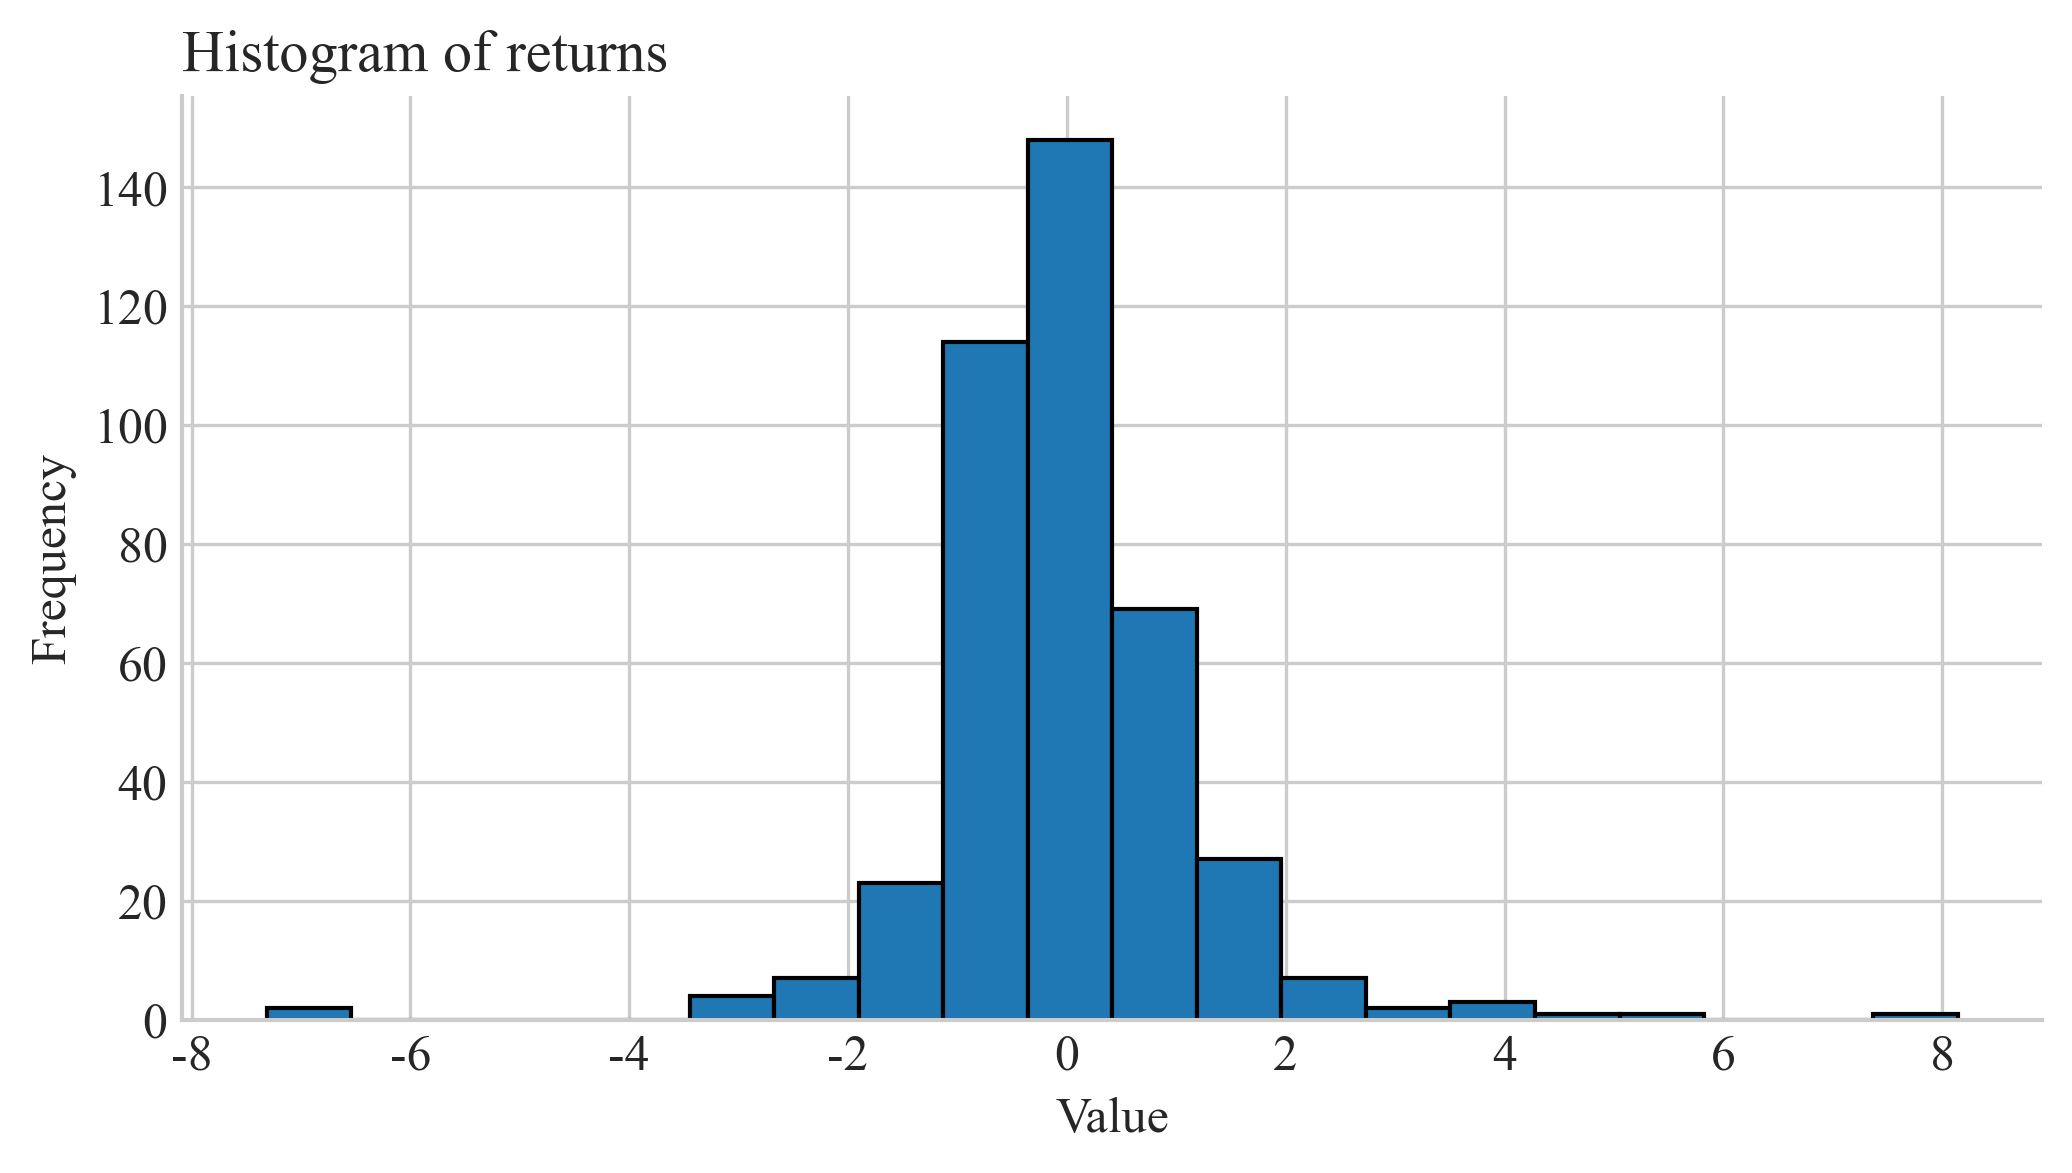

In [212]:
plt.hist(result['returns'], bins=20, edgecolor='k')
plt.title('Histogram of returns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [211]:
# 偏度检验
# 偏度 = 0：数据分布是对称的（例如正态分布）。
# 偏度 > 0：数据分布右偏（正偏），即数据的右尾较长，极端值集中在右侧。因此对变量进行对数变换减少右偏
# 偏度 < 0：数据分布左偏（负偏），即数据的左尾较长，极端值集中在左侧。
result['returns'].skew()

0.31584227418362704

In [210]:
# 峰度检验
# 峰度 = 3：数据分布接近正态分布。
# 峰度 > 3：数据分布更尖峭，尾部更厚（Leptokurtic）。
# 峰度 < 3：数据分布更平坦，尾部更薄（Platykurtic）
result['returns'].kurt()

12.140345985492353

#### return 分布检验和绘图（result）

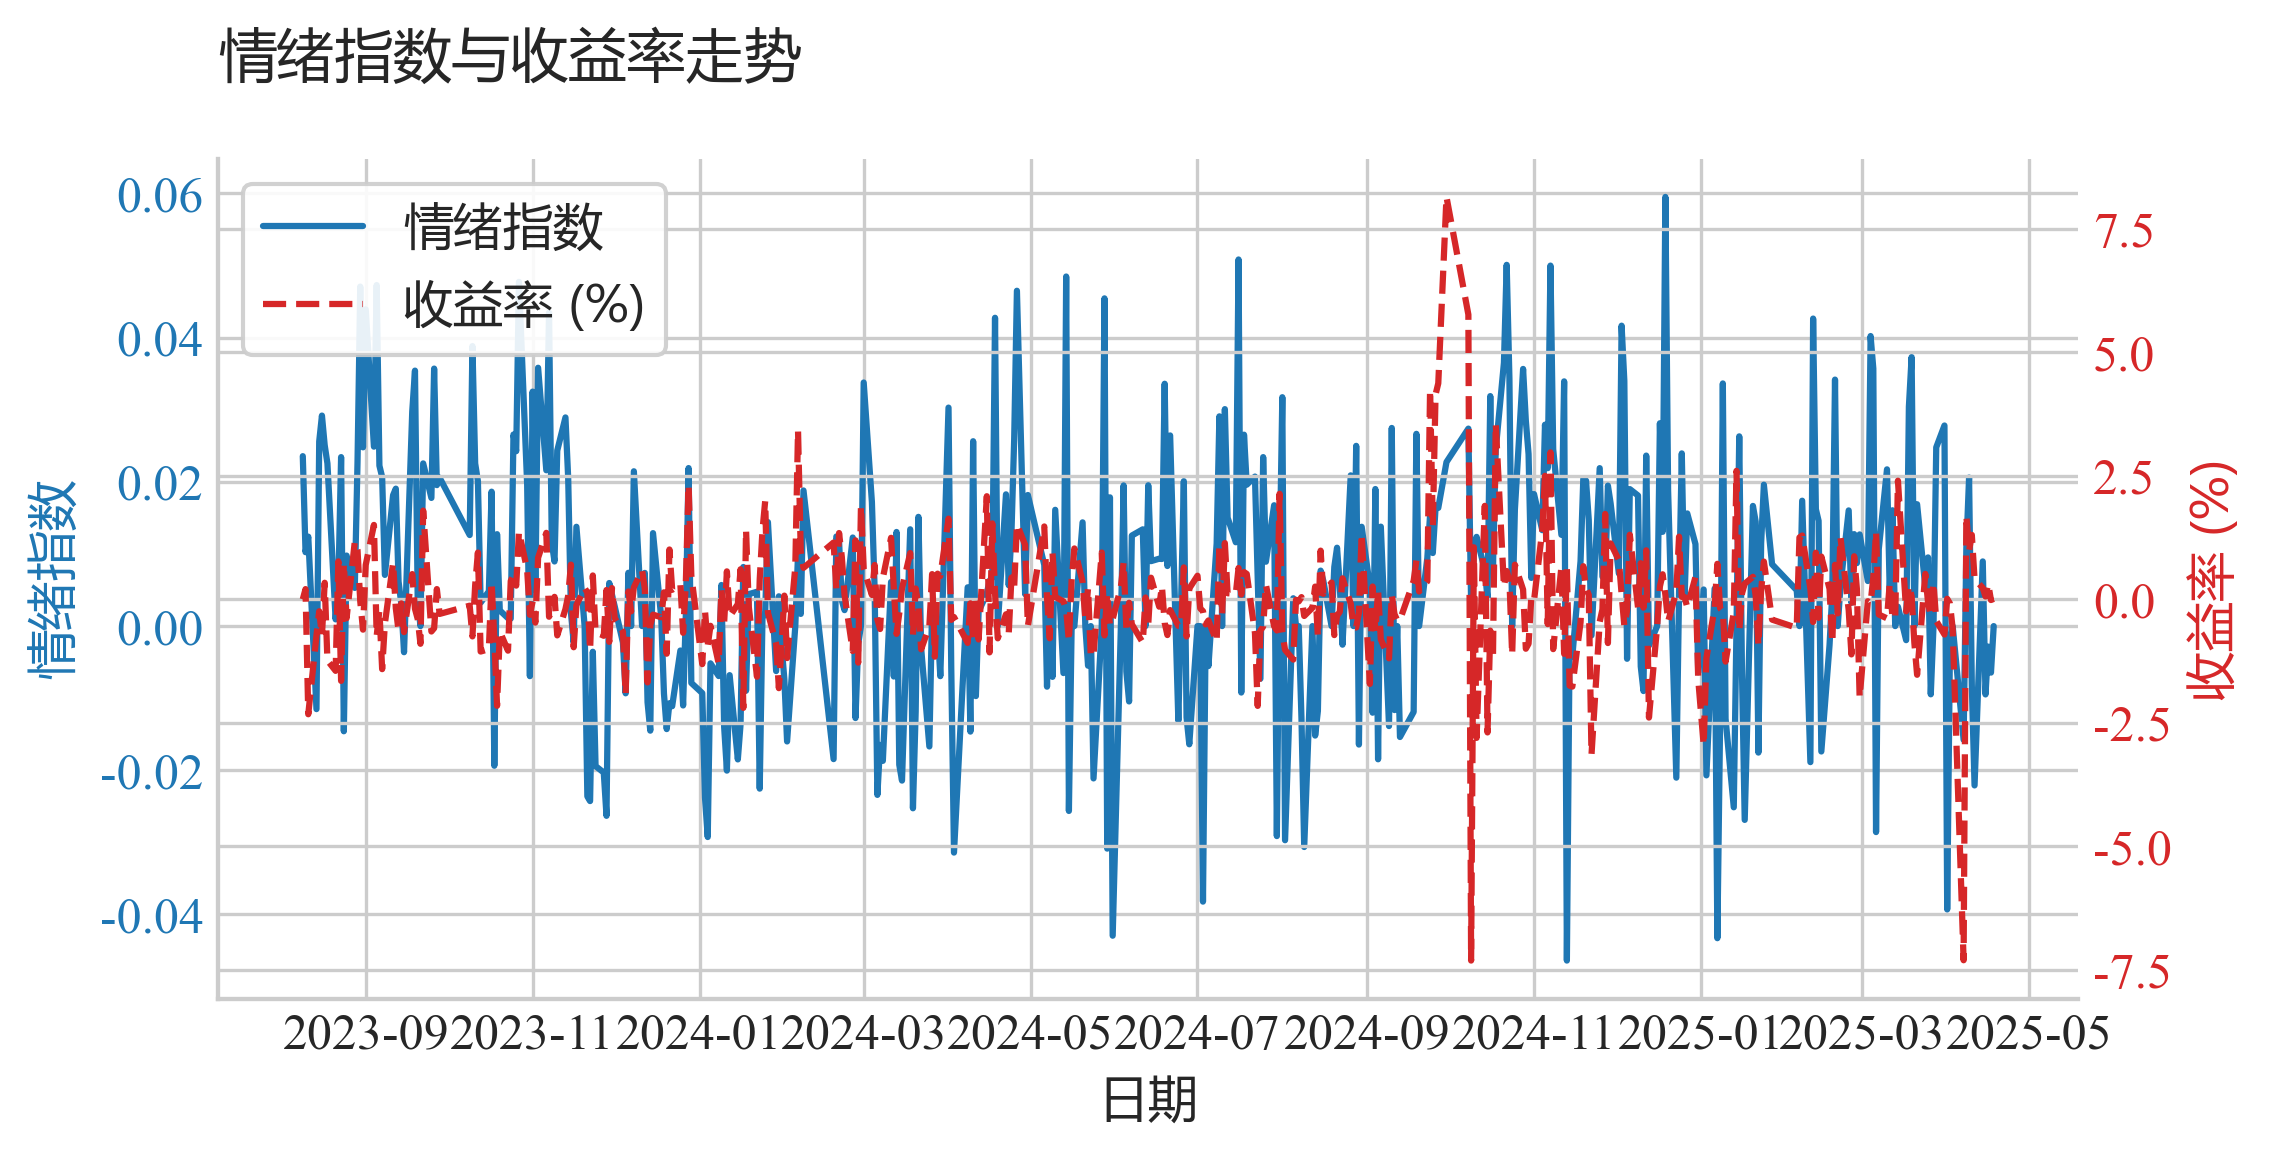

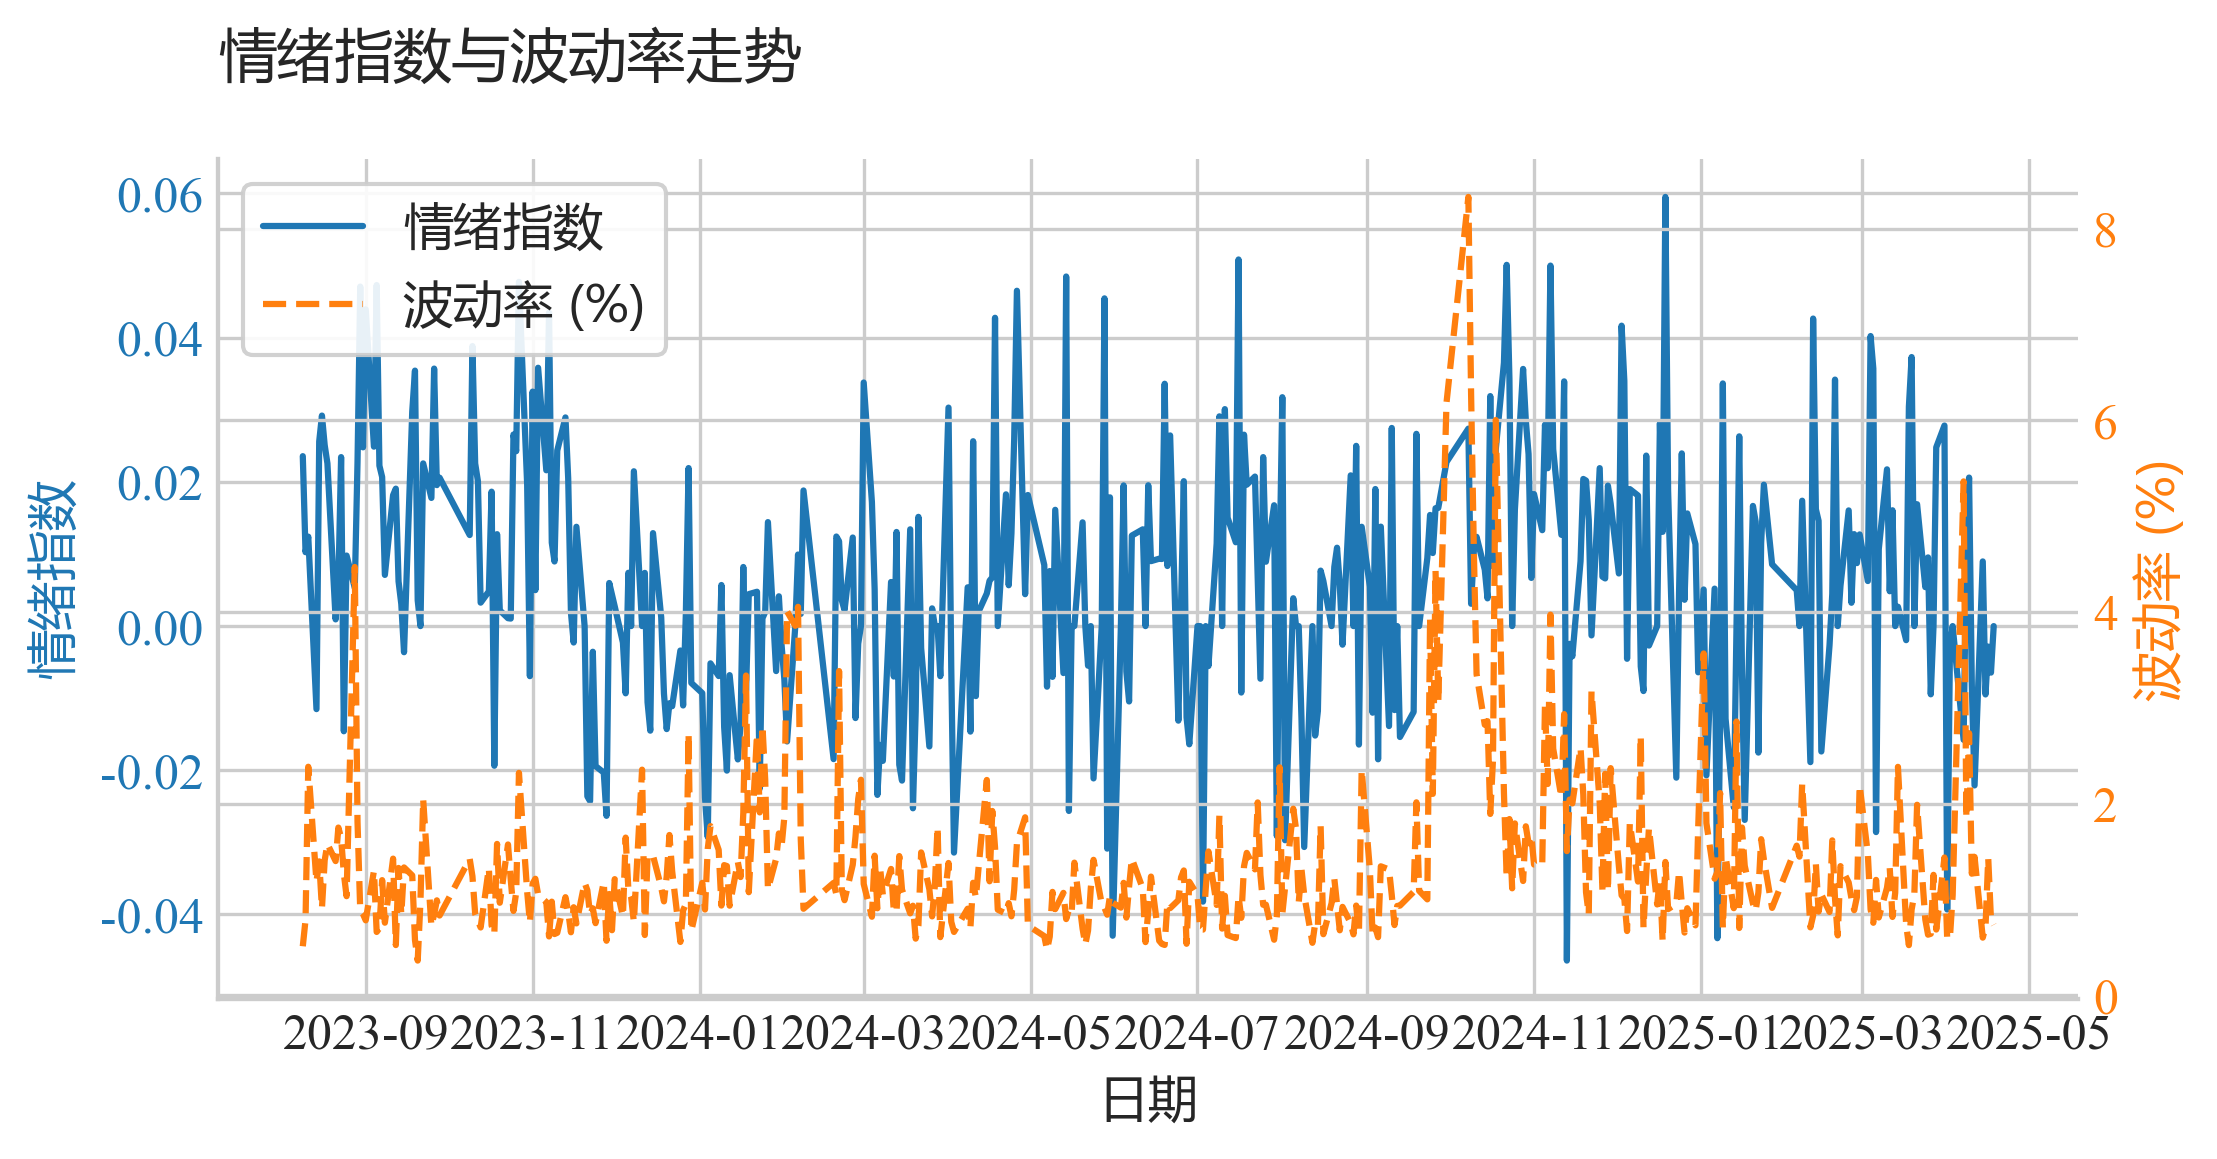

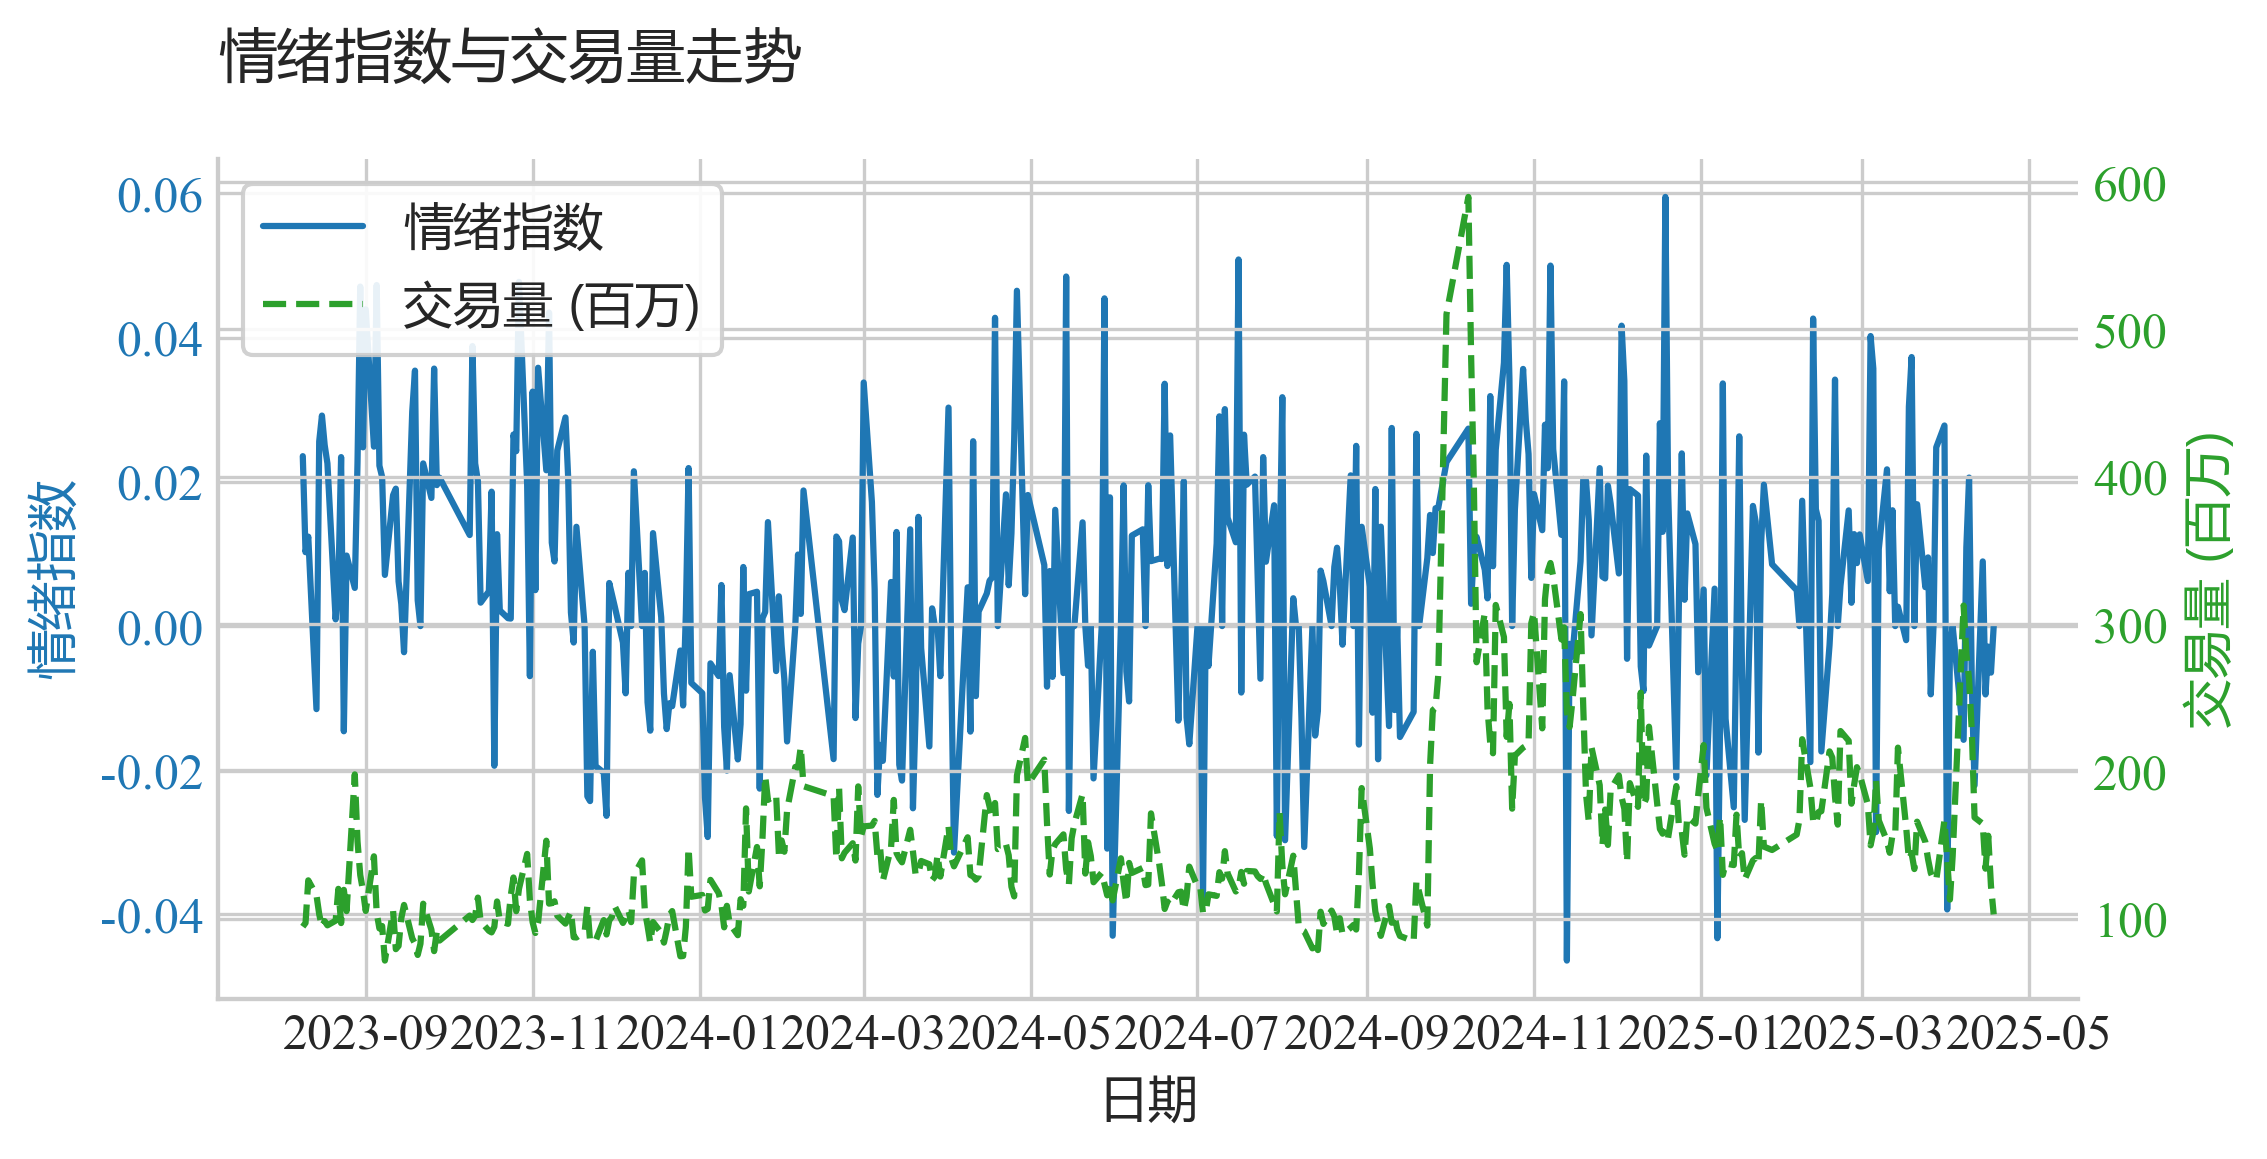

In [209]:
plot_dual_axis(
    x=result['trade_date'],
    y1=result['sentiment_index'],
    y2=result['returns'],
    y1_label='情绪指数',
    y2_label='收益率 (%)',
    title='情绪指数与收益率走势',
    colors=('#1f77b4', '#d62728'),  # 深蓝 + 红色
    save_path='sentiment_return.pdf'
)

# 图2：情绪指数 vs 波动率
plot_dual_axis(
    x=result['trade_date'],
    y1=result['sentiment_index'],
    y2=result['volatility'],
    y1_label='情绪指数',
    y2_label='波动率 (%)',
    title='情绪指数与波动率走势',
    colors=('#1f77b4', '#ff7f0e'),  # 深蓝 + 橙色
    save_path='sentiment_volatility.pdf'
)

# 图3：情绪指数 vs 交易量（需单位转换）
result['volume_million'] = result['vol'] / 1e6  # 转换为百万单位
plot_dual_axis(
    x=result['trade_date'],
    y1=result['sentiment_index'],
    y2=result['volume_million'],
    y1_label='情绪指数',
    y2_label='交易量 (百万)',
    title='情绪指数与交易量走势',
    colors=('#1f77b4', '#2ca02c'),  # 深蓝 + 绿色
    save_path='sentiment_volume.pdf'
)

### 统计性描述和绘图

In [203]:
from  matplotlib import pyplot as plt
from matplotlib import  font_manager
from matplotlib import dates as mdates

In [204]:
plt.style.use('seaborn-v0_8-whitegrid')  # 学术风格网格线
plt.rcParams.update({
    'font.family': 'Times New Roman',  # 主字体（英文字体）
    'font.size': 12,                   # 正文字体大小
    'axes.labelsize': 12,              # 坐标轴标签字体
    'axes.titlesize': 14,              # 标题字体
    'axes.titlelocation': 'left',      # 标题左对齐
    'axes.spines.right': False,        # 隐藏右侧边框
    'axes.spines.top': False,          # 隐藏顶部边框
    'figure.dpi': 300,                 # 输出分辨率
    'figure.figsize': (8, 4),          # 图表尺寸 (宽, 高)
    'legend.fontsize': 10,             # 图例字体
    'legend.frameon': True,            # 图例边框
    'mathtext.fontset': 'stix'         # 数学公式字体
})

In [205]:
font_path = "C:/Windows/Fonts/msyh.ttc"
font_manager.fontManager.addfont(font_path)
custom_zh_font = font_manager.FontProperties(fname=font_path).get_name()

In [206]:
plt.rcParams['font.sans-serif'] = [custom_zh_font] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示

In [207]:
zh_font = {'family': custom_zh_font, 'size': 12}

In [208]:
def plot_dual_axis(x, y1, y2, y1_label, y2_label, title,
                  colors=('#1f77b4', '#2ca02c'), save_path=None):
    """
    参数说明：
    x: x轴数据（日期）
    y1: 左侧Y轴数据（情绪指数）
    y2: 右侧Y轴数据（return/volatility/volume）
    colors: (左侧颜色, 右侧颜色)
    """
    # 创建字体配置对象
    en_font = {'family': 'Times New Roman', 'size': 12}
    zh_font = {'family': custom_zh_font, 'size': 12}

    fig, ax1 = plt.subplots()

    # 左侧Y轴：情绪指数（应用中文配置）
    ax1.plot(x, y1, color=colors[0], linewidth=1.5, label=y1_label)
    ax1.set_xlabel('日期', fontdict=zh_font)
    ax1.set_ylabel(y1_label, color=colors[0], fontdict=zh_font)
    ax1.tick_params(axis='y', labelcolor=colors[0])

    # 右侧Y轴：其他指标（保持英文配置）
    ax2 = ax1.twinx()
    ax2.plot(x, y2, color=colors[1], linewidth=1.5,
            linestyle='--', label=y2_label)
    ax2.set_ylabel(y2_label, color=colors[1], fontdict=zh_font)
    ax2.tick_params(axis='y', labelcolor=colors[1])

    # ========== 新增代码：日期轴优化 ==========
    # 自动选择刻度间隔（年/月/日）
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    # 格式化日期标签（示例：显示年-月）
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # 旋转标签并调整对齐方式
    plt.xticks(rotation=45, ha='right')
    # 调整底部边距防止标签被裁剪
    plt.subplots_adjust(bottom=0.18)

    # 标题配置（中文）
    plt.title(title, fontdict={**zh_font, 'size': 14}, pad=20)

    # 图例配置（混合字体）
    lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels,
              loc='upper left',
              prop=zh_font,
              framealpha=0.9)

    # 保存矢量图（确保字体嵌入）
    if save_path:
        plt.savefig(save_path,
                   bbox_inches='tight',
                   dpi=300,
                   metadata={'Creator': 'Your Name', 'Title': title})
    plt.show()

In [200]:
result['volatility'] = result['volatility'].fillna(0)

In [199]:
result['volatility'].head(3)

1    0.510217
2    0.784584
3    2.384298
Name: volatility, dtype: float64

In [198]:
# volatility
result['volatility'] = (result['high'] - result['low'])/((result['high']+result['low'])/2)*100

In [197]:
result.head(3)

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,...,total_mv,float_mv,turnover_rate,pe,pb,total_share,m2_yoy,sentiment_index,agreement_index,return
1,000300.SH,2023-08-09,3967.5652,3967.3566,3982.1091,3961.8434,3979.7322,-12.1670,-0.3057,94640269.0,...,5.099382e+13,3.926694e+13,0.31,12.19,1.40,4.065827e+12,11.258333,0.023569,0.000278,0.000000
2,000300.SH,2023-08-10,3975.7166,3962.8569,3976.4637,3945.3869,3967.5652,8.1514,0.2055,97176849.0,...,5.113598e+13,3.934532e+13,0.32,12.23,1.40,4.065827e+12,11.258333,0.010249,0.000053,0.205240
3,000300.SH,2023-08-11,3884.2538,3977.9834,3977.9834,3884.2538,3975.7166,-91.4628,-2.3005,126082931.0,...,5.007981e+13,3.848109e+13,0.41,11.97,1.37,4.065991e+12,11.258333,0.012405,0.000077,-2.327412


In [196]:
result['return'] = result['return'].fillna(0)

In [195]:
result.head(3)

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,...,total_mv,float_mv,turnover_rate,pe,pb,total_share,m2_yoy,sentiment_index,agreement_index,return
1,000300.SH,2023-08-09,3967.5652,3967.3566,3982.1091,3961.8434,3979.7322,-12.1670,-0.3057,94640269.0,...,5.099382e+13,3.926694e+13,0.31,12.19,1.40,4.065827e+12,11.258333,0.023569,0.000278,NaN
2,000300.SH,2023-08-10,3975.7166,3962.8569,3976.4637,3945.3869,3967.5652,8.1514,0.2055,97176849.0,...,5.113598e+13,3.934532e+13,0.32,12.23,1.40,4.065827e+12,11.258333,0.010249,0.000053,0.205240
3,000300.SH,2023-08-11,3884.2538,3977.9834,3977.9834,3884.2538,3975.7166,-91.4628,-2.3005,126082931.0,...,5.007981e+13,3.848109e+13,0.41,11.97,1.37,4.065991e+12,11.258333,0.012405,0.000077,-2.327412


In [194]:
# 对数收益率
result['return'] = np.log(result['close']/result['close'].shift(1))*100

In [193]:
result['agreement_index'] = result['sentiment_index'].apply(lambda x : 1-np.sqrt(1-x**2))

In [192]:
result.head(3)

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,total_mv,float_mv,turnover_rate,pe,pb,total_share,m2_yoy,sentiment_index
1,000300.SH,2023-08-09,3967.5652,3967.3566,3982.1091,3961.8434,3979.7322,-12.1670,-0.3057,94640269.0,1.743942e+08,5.099382e+13,3.926694e+13,0.31,12.19,1.40,4.065827e+12,11.258333,0.023569
2,000300.SH,2023-08-10,3975.7166,3962.8569,3976.4637,3945.3869,3967.5652,8.1514,0.2055,97176849.0,1.756467e+08,5.113598e+13,3.934532e+13,0.32,12.23,1.40,4.065827e+12,11.258333,0.010249
3,000300.SH,2023-08-11,3884.2538,3977.9834,3977.9834,3884.2538,3975.7166,-91.4628,-2.3005,126082931.0,2.035463e+08,5.007981e+13,3.848109e+13,0.41,11.97,1.37,4.065991e+12,11.258333,0.012405


In [191]:
result = result[1:].copy()

In [479]:
# 工具变量
result = result.merge(baidu_index[['trade_date', 'baidu_index']], on='trade_date', how='left', validate='1:1')

In [190]:
result.tail(3)

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,total_mv,float_mv,turnover_rate,pe,pb,total_share,m2_yoy,sentiment_index
407,000300.SH,2025-04-16,3772.8204,3757.8757,3775.1661,3721.6025,3761.2348,11.5856,0.3080,156359006.0,2.617111e+08,5.586239e+13,4.197110e+13,0.48,12.09,1.32,4.210550e+12,6.891667,-0.002849
408,000300.SH,2025-04-17,3772.2221,3755.0862,3779.1253,3749.5040,3772.8204,-0.5983,-0.0159,122371002.0,2.090123e+08,5.586207e+13,4.197099e+13,0.38,12.09,1.31,4.210550e+12,6.891667,-0.006452
409,000300.SH,2025-04-18,3772.5230,3760.0425,3782.0443,3754.4072,3772.2221,0.3009,0.0080,102948509.0,1.731094e+08,5.593480e+13,4.198855e+13,0.32,12.10,1.31,4.210865e+12,6.891667,0.000000


In [189]:
result.head(3)

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,total_mv,float_mv,turnover_rate,pe,pb,total_share,m2_yoy,sentiment_index
0,000300.SH,2023-08-08,3979.7322,3980.0423,4002.2904,3963.4632,3990.1531,-10.4209,-0.2612,109871699.0,2.026113e+08,5.114554e+13,3.938285e+13,0.36,12.23,1.4,4.065758e+12,11.258333,NaN
1,000300.SH,2023-08-09,3967.5652,3967.3566,3982.1091,3961.8434,3979.7322,-12.1670,-0.3057,94640269.0,1.743942e+08,5.099382e+13,3.926694e+13,0.31,12.19,1.4,4.065827e+12,11.258333,0.023569
2,000300.SH,2023-08-10,3975.7166,3962.8569,3976.4637,3945.3869,3967.5652,8.1514,0.2055,97176849.0,1.756467e+08,5.113598e+13,3.934532e+13,0.32,12.23,1.4,4.065827e+12,11.258333,0.010249


In [ ]:
### 个股数据分析

In [188]:
result = SentimentIndex(df, HS300)

### 文本数据和股票数据结合

#### 指数 PE,PB,turn_over

In [384]:
stock = stock.sort_values(by=['trade_date'], ascending=True).reset_index(drop=True)

In [385]:
stock.head(3)

,ts_code,trade_date,close,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,600036.SH,20241015,38.50,0.4634,0.9029,0.57,6.6231,6.6690,1.0117,2.8632,2.9105,4.5143,5.1220,2.521985e+06,2.062894e+06,1.058737e+06,9.709641e+07,7.942144e+07
1,600036.SH,20241016,39.50,0.4908,0.9564,0.79,6.7952,6.8423,1.0379,2.9375,2.9861,4.4000,4.9924,2.521985e+06,2.062894e+06,1.058737e+06,9.961839e+07,8.148433e+07
2,600036.SH,20241017,38.49,0.4115,0.8018,0.76,6.6214,6.6673,1.0114,2.8624,2.9097,4.5154,5.1234,2.521985e+06,2.062894e+06,1.058737e+06,9.707119e+07,7.940081e+07


In [166]:
df['post_date'] = pd.to_datetime(df['post_date'])

In [165]:
df['snownlp'] = df['post_title'].apply(lambda x : SnowNLP(x).sentiments)

KeyboardInterrupt: 

### 情感分析

In [326]:
from transformers import BertTokenizer, BertForSequenceClassification,pipeline
import torch

#### 1.Finbert

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch

def finbert_sentiment_analysis(texts, batch_size=8):
    """
    金融文本情感分类函数

    参数:
        texts (str/list): 输入文本（支持单条文本或列表批量输入）
        batch_size (int): 批量处理大小（根据GPU显存调整）

    返回:
        list: 包含每条文本分类结果的字典列表
    """
    # 1. 加载预训练模型和分词器
    model_name = "yiyanghkust/finbert-tone"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)

    # 2. 创建分类Pipeline
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1,  # 自动选择GPU/CPU
        framework="pt",
        truncation=True,  # 处理长文本自动截断
        batch_size=batch_size
    )

    # 3. 执行分类（自动处理单条/批量输入）
    results = classifier(texts)

    # 4. 格式化输出结果
    return [
        {
            "text": text,
            "label": result["label"],
            "score": round(result["score"], 4)
        }
        for text, result in zip(
            [texts] if isinstance(texts, str) else texts,  # 统一处理单条输入
            results
        )
    ]

# ===================== 使用示例 =====================
if __name__ == "__main__":
    texts = df['poot_title'].to_list()
    # 示例文本（支持英文/金融专业术语）
    example_texts = [
        "Apple reported record-breaking quarterly earnings, exceeding analysts' expectations.",
        "The Federal Reserve announced a 0.5% interest rate hike amid rising inflation concerns.",
        "Tesla shares plummeted 12% after disappointing Q4 delivery numbers."
    ]

    # 执行分类
    results = finbert_sentiment_analysis(texts)

    # 打印结果
    for idx, result in enumerate(results):
        print(f"文本 {idx+1}:")
        print(f"内容: {result['text']}")
        print(f"情感: {result['label']} (置信度: {result['score']})")
        print("-" * 50)

In [160]:
#Handle missing values if any
missing_values = df.isnull().sum()
missing_values

post_title       0
post_view        0
comment_num      0
post_date        0
post_datetime    0
dtype: int64

#### 2. Financial dict

#### 单位根平稳性检验

In [299]:
# 对每列进行单位根检验
for column in data_processed.columns:
    print(f"单位根检验 - {column}:")
    adf_test(data_processed[column])

单位根检验 - trade_date:
ADF Statistic: 5.931279063983814
p-value: 1.0
Critical Values:
	1%: -3.4468876315017423
	5%: -2.868829424528516
	10%: -2.570653059771218
序列不平稳
单位根检验 - sentiment_index_square:
ADF Statistic: -12.228122392634896
p-value: 1.0688561208709891e-22
Critical Values:
	1%: -3.4465195891135845
	5%: -2.8686676281678634
	10%: -2.5705668101226085
序列平稳
单位根检验 - agreement_index:
ADF Statistic: -12.228437016190862
p-value: 1.0671861682818247e-22
Critical Values:
	1%: -3.4465195891135845
	5%: -2.8686676281678634
	10%: -2.5705668101226085
序列平稳
单位根检验 - volatility:
ADF Statistic: -4.972269657702822
p-value: 2.5175391112829225e-05
Critical Values:
	1%: -3.44664043608676
	5%: -2.868720756230461
	10%: -2.5705951311145965
序列平稳
单位根检验 - pe_new:
ADF Statistic: -1.9173345561024049
p-value: 0.3239508419374717
Critical Values:
	1%: -3.44664043608676
	5%: -2.868720756230461
	10%: -2.5705951311145965
序列不平稳
单位根检验 - pe:
ADF Statistic: -1.9447254411019048
p-value: 0.3113219963117376
Critical Values:
	1

In [264]:
##### 数据处理

In [300]:
for column in ['pe_new', 'pb_new', 'turnover_rate_new', 'm2_yoy']:
    data_processed[column] = data_processed[column].diff()

In [ ]:
for column in ['pe_new', 'pb_new', 'turnover_rate_new', 'm2_yoy']:
    print(f"\n=== {column} 平稳性检验 ===")
    test_stationarity(data_processed[column])

In [302]:
missing_values = data_processed.isnull().sum()
missing_values

trade_date                0
sentiment_index_square    0
agreement_index           0
volatility                0
pe_new                    1
pe                        0
pb                        0
pb_new                    1
m2_yoy                    1
turnover_rate_new         1
returns_new               0
log_volatility            0
sentiment_index           0
sentiment_index_lag_1     0
dtype: int64

In [303]:
data_processed = data_processed.bfill()

#### 协整分析

In [ ]:
# 协整分析
test_columns = ['returns', 'volume_diff1', 'volatility', 'sentiment_index', 'agreement_index']
variables = data_processed[test_columns].values
johansen_result = coint_johansen(variables, det_order=0, k_ar_diff=1)
print("迹统计量:")
print(johansen_result.lr1)
print("临界值:")
print(johansen_result.cvt)
print("特征值:")
print(johansen_result.eig)

In [600]:
# 协整分析
# 检验情绪指数与收益率的长期均衡关系
score, pvalue, _ = coint(data_processed['sentiment_index'],
                        data_processed['volume_million'],
                        trend='c',  # 包含常数项
                        maxlag=5)   # 最大滞后阶数

print(f'协整检验p值: {pvalue:.4f}')
if pvalue < 0.05:
    print("拒绝无协整假设，存在长期均衡关系")
else:
    print("未发现显著协整关系")

协整检验p值: 0.0000
拒绝无协整假设，存在长期均衡关系


#### VIF 计算

In [ ]:
# VIF计算
vif_data = pd.DataFrame()
X = data.copy()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

### 面板回归建模与内生性处理

#### 个股数据处理

In [188]:
full_stock.head(3)

,ts_code,trade_date,open,high,low,close,vol,amount,turnover_rate,pe,pb,sentiment_index
0,000333.SZ,2025-02-10,73.32,73.33,72.50,73.01,318649.87,2324957.366,0.4623,16.5817,2.6772,0.000000
1,000333.SZ,2025-02-11,73.44,73.86,72.61,73.70,300440.16,2200715.457,0.4359,16.7384,2.7025,0.016949
2,000333.SZ,2025-02-12,73.46,73.59,72.68,73.28,228072.78,1667138.730,0.3309,16.6430,2.6871,-0.006543


#### 数据格式转换（面板结构）

In [538]:
# 假设数据包含个股代码（示例添加虚拟代码）
data_processed['stock_id'] = 'HS300'  # 沪深300作为唯一个体
data_panel = data_processed.set_index(['stock_id', data_processed.index])

In [539]:
data_panel

trade_date  sentiment_index  agreement_index  snownlp_index  \
stock_id                                                                   
HS300    0   2023-08-08         0.031550         0.000498       0.640500   
         1   2023-08-09         0.023569         0.000278       0.634315   
         2   2023-08-10         0.010249         0.000053       0.580220   
         3   2023-08-11         0.012405         0.000077       0.551872   
         4   2023-08-14        -0.011516         0.000066       0.487191   
...                 ...              ...              ...            ...   
         405 2025-04-14         0.008969         0.000040       0.620814   
         406 2025-04-15        -0.009479         0.000045       0.380380   
         407 2025-04-16        -0.002849         0.000004       0.472856   
         408 2025-04-17        -0.006452         0.000021       0.387896   
         409 2025-04-18         0.000000         0.000000       0.531284   

              baidu_index    return  volatility  volume_diff1  volume_million  
stock_id                                                                       
HS300    0         1611.0  0.010696   -0.418223      0.000525        0.073777  
         1         1567.0 -0.240437   -0.930105     -0.473032        0.044386  
         2         1556.0  0.179031   -0.627839      0.079389        0.049281  
         3         1783.0 -1.898206    1.134541      0.899237        0.105059  
         4         2093.0 -0.590077   -0.188575     -0.314008        0.085538  
...                   ...       ...         ...           ...             ...  
         405       1300.0  0.199107   -0.830917     -0.133081        0.179118  
         406       1180.0  0.056341   -0.709913     -0.946386        0.120348  
         407       1227.0  0.262946    0.082080      0.695496        0.163481  
         408       1211.0 -0.002311   -0.625290     -1.056188        0.097896  
         409       1183.0  0.017239   -0.684200     -0.603335        0.060418  

[410 rows x 9 columns]

#### 固定效应 vs 随机效应回归

In [ ]:
# 2.1 固定效应模型
fe_model = PanelOLS.from_formula(
    'return ~ 1 + sentiment_index + EntityEffects',
    data=data_panel
)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)

#### OLS 回归模型

In [304]:
## sentiment_index > 0
data_processed_pos = data_processed[data_processed['sentiment_index'] > 0].copy()
data_processed_neg = data_processed[data_processed['sentiment_index'] < 0].copy()

In [305]:
len(data_processed_neg)

212

In [306]:
len(data_processed_pos)

197

In [307]:
len(data_processed)

409

##### 1.1 returns 回归含 sentiment_index， agreement_index

In [274]:
# 2.1分别将投资者情绪对对数收益率、成交量、波动率进行 OLS 回归
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['sentiment_index', 'agreement_index', 'pe_new', 'pb_new', 'm2_yoy', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:            returns_new   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     270.0
Date:                Wed, 07 May 2025   Prob (F-statistic):          1.26e-137
Time:                        01:39:38   Log-Likelihood:                -249.48
No. Observations:                 409   AIC:                             513.0
Df Residuals:                     402   BIC:                             541.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -

##### 1.2 returns 回归含 sentiment_index

In [278]:
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['sentiment_index','pe_new', 'pb_new', 'm2_yoy', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:            returns_new   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     322.3
Date:                Wed, 07 May 2025   Prob (F-statistic):          2.31e-138
Time:                        01:45:57   Log-Likelihood:                -250.75
No. Observations:                 409   AIC:                             513.5
Df Residuals:                     403   BIC:                             537.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 

In [313]:
# VIF计算
vif_data = pd.DataFrame()
X = data_processed[['sentiment_index_lag_1','sentiment_index','agreement_index','pe_new', 'pb_new', 'turnover_rate_new']].copy()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [314]:
vif_data

,Variable,VIF
0,sentiment_index_lag_1,1.043126
1,sentiment_index,1.192295
2,agreement_index,1.193923
3,pe_new,5.903474
4,pb_new,5.697523
5,turnover_rate_new,1.089825


In [285]:
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['sentiment_index','pe_new', 'pb_new', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:            returns_new   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     403.3
Date:                Wed, 07 May 2025   Prob (F-statistic):          1.36e-139
Time:                        01:58:09   Log-Likelihood:                -250.98
No. Observations:                 409   AIC:                             512.0
Df Residuals:                     404   BIC:                             532.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 

In [ ]:
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['sentiment_index','pe_new', 'pb_new', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

##### 1.3 returns 回归不含 sentiment

In [277]:
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['pe_new', 'pb_new', 'm2_yoy', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:            returns_new   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     394.5
Date:                Wed, 07 May 2025   Prob (F-statistic):          4.85e-138
Time:                        01:42:39   Log-Likelihood:                -254.60
No. Observations:                 409   AIC:                             519.2
Df Residuals:                     404   BIC:                             539.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 

In [308]:
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['sentiment_index_square', 'pe_new', 'pb_new', 'm2_yoy', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:            returns_new   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     321.7
Date:                Wed, 07 May 2025   Prob (F-statistic):          3.19e-138
Time:                        02:11:06   Log-Likelihood:                -251.08
No. Observations:                 409   AIC:                             514.2
Df Residuals:                     403   BIC:                             538.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const       

##### 1.4 returns 回归 sentiment_index_lag_1

In [316]:
y_return = data_processed['returns_new']
X = sm.add_constant(data_processed[['sentiment_index_lag_1', 'pe_new', 'pb_new', 'm2_yoy', 'turnover_rate_new']])

model_return_ols = sm.OLS(y_return, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:            returns_new   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     316.7
Date:                Wed, 07 May 2025   Prob (F-statistic):          4.01e-137
Time:                        02:15:18   Log-Likelihood:                -253.65
No. Observations:                 409   AIC:                             519.3
Df Residuals:                     403   BIC:                             543.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const         

##### 2.1 log_volatility

In [276]:
# 2.1分别将投资者情绪对对数收益率、成交量、波动率进行 OLS 回归
y_volatility = data_processed['log_volatility']
X = sm.add_constant(data_processed[['sentiment_index', 'agreement_index', 'pe_new', 'pb_new', 'm2_yoy', 'turnover_rate_new']])

model_volatility_ols = sm.OLS(y_volatility, X).fit()

print("波动率 OLS 回归结果:")
print(model_volatility_ols.summary())

波动率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:         log_volatility   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     16.16
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.10e-16
Time:                        01:41:16   Log-Likelihood:                -535.65
No. Observations:                 409   AIC:                             1085.
Df Residuals:                     402   BIC:                             1113.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.

In [317]:
# 2.1分别将投资者情绪对对数收益率、成交量、波动率进行 OLS 回归
y_volatility = data_processed['log_volatility']
X = sm.add_constant(data_processed['sentiment_index_lag_1'])

model_volatility_ols = sm.OLS(y_volatility, X).fit()
print(model_volatility_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         log_volatility   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8142
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.367
Time:                        02:15:58   Log-Likelihood:                -579.44
No. Observations:                 409   AIC:                             1163.
Df Residuals:                     407   BIC:                             1171.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.605e-

In [261]:
y_return = data_processed['returns']
#y_volume = data_processed['volume_diff1']
y_volatility = data_processed['volatility']
X = sm.add_constant(data_processed['agreement_index'])

model_return_ols = sm.OLS(y_return, X).fit()
#model_volume_ols = sm.OLS(y_volume, X).fit()
model_volatility_ols = sm.OLS(y_volatility, X).fit()

print("对数收益率 OLS 回归结果:")
print(model_return_ols.summary())
print("成交量一阶差分 OLS 回归结果:")
# print(model_volume_ols.summary())
print("波动率 OLS 回归结果:")
print(model_volatility_ols.summary())

对数收益率 OLS 回归结果:
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.454
Date:                Tue, 06 May 2025   Prob (F-statistic):              0.120
Time:                        12:02:56   Log-Likelihood:                -178.47
No. Observations:                 127   AIC:                             360.9
Df Residuals:                     125   BIC:                             366.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0845

### 格兰杰因果检验

In [324]:
test_data = data_processed[['returns_new', 'sentiment_index_square']].dropna()
granger_test = grangercausalitytests(test_data, maxlag=8)  # 检验滞后1-3期


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7184  , p=0.3972  , df_denom=405, df_num=1
ssr based chi2 test:   chi2=0.7237  , p=0.3949  , df=1
likelihood ratio test: chi2=0.7231  , p=0.3951  , df=1
parameter F test:         F=0.7184  , p=0.3972  , df_denom=405, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0602  , p=0.3474  , df_denom=402, df_num=2
ssr based chi2 test:   chi2=2.1468  , p=0.3418  , df=2
likelihood ratio test: chi2=2.1411  , p=0.3428  , df=2
parameter F test:         F=1.0602  , p=0.3474  , df_denom=402, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7520  , p=0.5217  , df_denom=399, df_num=3
ssr based chi2 test:   chi2=2.2954  , p=0.5134  , df=3
likelihood ratio test: chi2=2.2890  , p=0.5146  , df=3
parameter F test:         F=0.7520  , p=0.5217  , df_denom=399, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6066  , p=0.6581  

### 内生性判断与IV回归

In [640]:
# 3.1 内生性检验（Durbin-Wu-Hausman）
from statsmodels.stats.stattools import durbin_watson

# 第一阶段：内生变量对工具变量回归
first_stage = IV2SLS.from_formula(
    'sentiment_index ~ 1 + sentiment_index_lag_2',
    data=data_processed
).fit()
print("第一阶段F统计量:", first_stage.f_statistic.stat)

# 弱工具变量检验（Cragg-Donald Wald F统计量）
if first_stage.f_statistic.stat > 10:
    print("工具变量强度足够 (F > 10)")
else:
    print("可能存在弱工具变量问题")

# 3.2 两阶段最小二乘法（2SLS）
iv_model = IV2SLS.from_formula(
    'returns ~ 1 + [sentiment_index ~ sentiment_index_lag_2]',
    data=data_processed
)
iv_results = iv_model.fit()
print(iv_results.summary)

# 对比OLS估计（可能因内生性有偏）
ols_model = sm.OLS.from_formula(
    'returns ~ 1 + baidu_index',
    data=data_processed
).fit(cov_type='HC3')

print(ols_model.summary())


# 3.3 过度识别检验（需多个工具变量）
# 示例添加第二个工具变量（假设存在news_sentiment）
# iv_model_overid = IV2SLS.from_formula(
#     'return ~ 1 + [sentiment_index ~ Baidu_index + news_sentiment]',
#     data=data_panel
# )
# overid_test = iv_model_overid.fit().sargan
# print(f"Sargan检验p值: {overid_test.pval:.4f}")

# 3.4 输出关键结果
print(iv_results.summary)

第一阶段F统计量: 15.228062235164524
工具变量强度足够 (F > 10)
                          IV-2SLS Estimation Summary                          
Dep. Variable:                returns   R-squared:                      0.0074
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0050
No. Observations:                 409   F-statistic:                    0.0133
Date:                Tue, May 06 2025   P-value (F-stat)                0.9083
Time:                        14:37:04   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept          -0.0088     0.0830    -0.1058     0.9158     -0.17

In [101]:
data.to_csv('sentiment_result.csv', index=False)